In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import random
import math

In [2]:
with open('../../../data/event000000000-spacepoint.csv', 'r', encoding='utf8') as file:
    lines = file.readlines()

for line in lines[:5]:
    print(line, end='')

measurement_id,geometry_id,x,y,z,var_r,var_z
0,1152921779484760320,156.76506,-5.30625391,-1523.19995,0.000899999985,8.43614858e-37
1,1152921779484760576,153.652435,25.7113953,-1524.40002,0.000899999985,8.43614858e-37
2,1152921779484760576,154.974457,28.9229641,-1524.40002,0.000899999985,8.43614858e-37
3,1152921779484760832,-15.4573355,157.548386,-1523.19995,0.000899999985,8.43614858e-37


In [3]:
points = []
for line in lines[1:]:
    point_variables = line.strip().split(',')
    point = {
        'x': float(point_variables[2]),
        'y': float(point_variables[3]),
        'z': float(point_variables[4]),
    }
    points.append(point)

print(points[0])

{'x': 156.76506, 'y': -5.30625391, 'z': -1523.19995}


In [22]:
min_x = min([point['x'] for point in points])
max_x = max([point['x'] for point in points])
min_y = min([point['y'] for point in points])
max_y = max([point['y'] for point in points])
min_z = min([point['z'] for point in points])
max_z = max([point['z'] for point in points])

print("min_x: ", min_x)
print("max_x: ", max_x)
print("min_y: ", min_y)
print("max_y: ", max_y)
print("min_z: ", min_z)
print("max_z: ", max_z)

min_x:  -1030.81348
max_x:  1029.92615
min_y:  -1028.98901
max_y:  1030.02991
min_z:  -3025.5
max_z:  3025.5


In [23]:
class DetectorProperties:
    max_abs_xy = 1100
    max_abs_z = 3100

In [26]:
def get_3d_plot_figure(figure_size, keep_aspect_ratio=False):
    figure = plt.figure(figsize=figure_size)
    ax = plt.axes(projection='3d')
    ax.set_xlim([-DetectorProperties.max_abs_z, DetectorProperties.max_abs_z] if keep_aspect_ratio else [-DetectorProperties.max_abs_xy, DetectorProperties.max_abs_xy])
    ax.set_ylim([-DetectorProperties.max_abs_z, DetectorProperties.max_abs_z])
    ax.set_zlim([-DetectorProperties.max_abs_z, DetectorProperties.max_abs_z] if keep_aspect_ratio else [-DetectorProperties.max_abs_xy, DetectorProperties.max_abs_xy])
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_facecolor('black')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.zaxis.label.set_color('white')
    return figure, ax

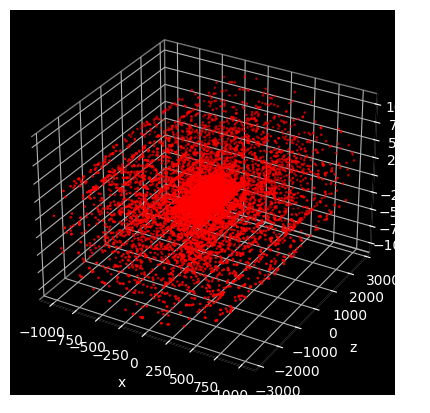

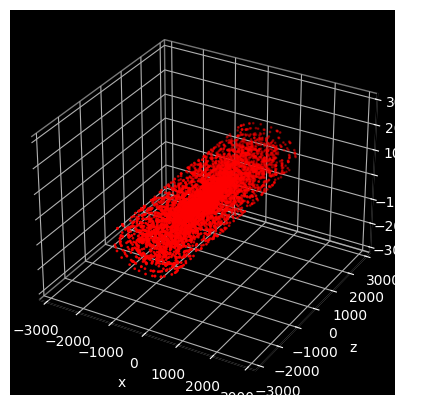

In [30]:
def plot_points(points, sample_size=None, figure=None, ax=None, keep_aspect_ratio=False, figure_size=(10, 10), point_size=4, color='red'):
    if figure is None or ax is None:
        figure, ax = get_3d_plot_figure(figure_size=figure_size, keep_aspect_ratio=keep_aspect_ratio)

    points_to_plot = random.sample(points, sample_size) if sample_size is not None else points
    points_x = [point['x'] for point in points_to_plot]
    points_y = [point['y'] for point in points_to_plot]
    points_z = [point['z'] for point in points_to_plot]
    ax.scatter3D(points_x, points_z, points_y, color=color, s=point_size)

plot_points(points, 10000, figure_size=(5, 5), point_size=1)
plot_points(points, 10000, figure_size=(5, 5), keep_aspect_ratio=True, point_size=1)

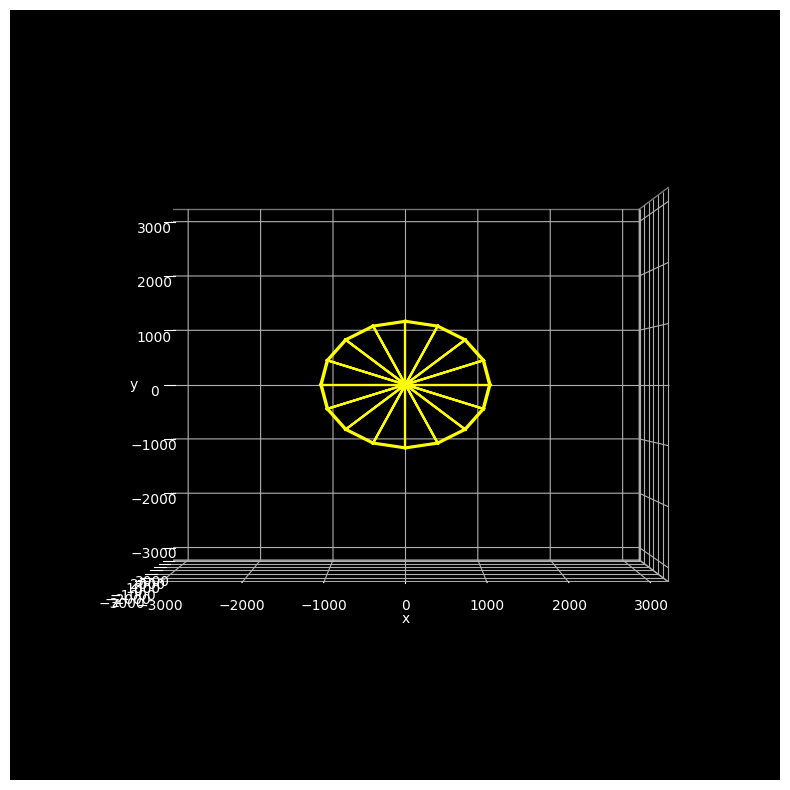

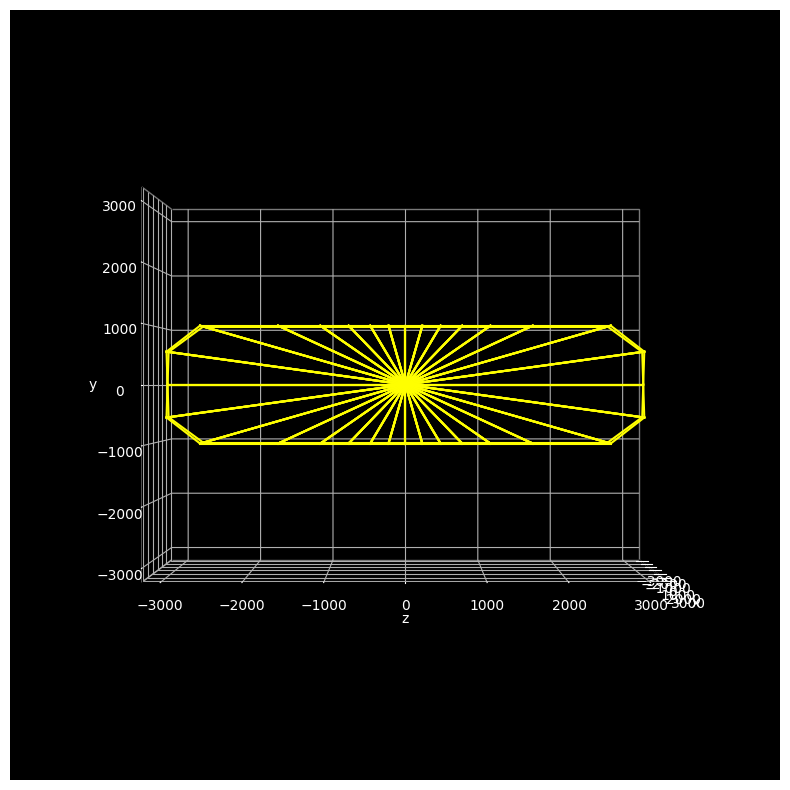

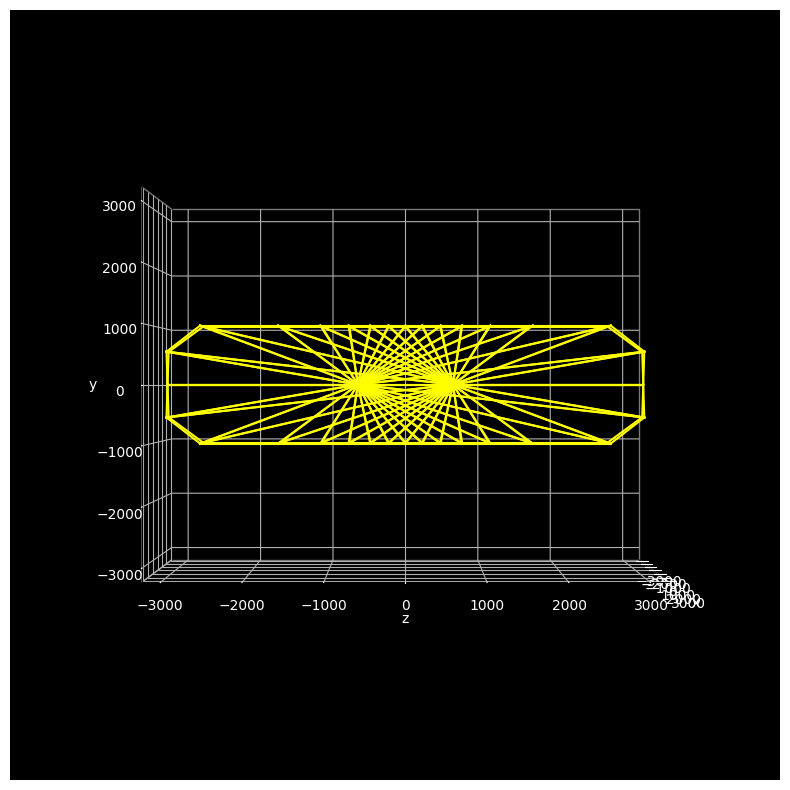

In [37]:
class Wedge:
    def __init__(self, z_angle_min, z_angle_max, x_angle_min, x_angle_max, interaction_region_width):
        self.z_angle_min = z_angle_min
        self.z_angle_max = z_angle_max
        self.x_angle_min = x_angle_min
        self.x_angle_max = x_angle_max
        self.interaction_region_width = interaction_region_width

    def get_outermost_points(self):
        def angles_to_xyz(z_angle, x_angle):
            x_plane_direction_z = math.cos(x_angle)
            x_plane_direction_y = math.sin(x_angle)

            x_plane_scale_to_z_limit = abs(x_plane_direction_z) / DetectorProperties.max_abs_z
            x_plane_scale_to_y_limit = abs(x_plane_direction_y) / DetectorProperties.max_abs_xy
            scale = 1 / max(x_plane_scale_to_z_limit, x_plane_scale_to_y_limit)
            
            return {
                'x': x_plane_direction_y * math.cos(z_angle) * scale,
                'y': x_plane_direction_y * math.sin(z_angle) * scale,
                'z': x_plane_direction_z * scale
            }

        return {
            'z_angle_min_x_angle_min': angles_to_xyz(self.z_angle_min, self.x_angle_min),
            'z_angle_min_x_angle_max': angles_to_xyz(self.z_angle_min, self.x_angle_max),
            'z_angle_max_x_angle_min': angles_to_xyz(self.z_angle_max, self.x_angle_min),
            'z_angle_max_x_angle_max': angles_to_xyz(self.z_angle_max, self.x_angle_max)
        }
    
    def get_interaction_region_zs(self):
        return {
            'x_angle_min': (1 if self.x_angle_min <= math.pi else -1) * self.interaction_region_width / 2,
            'x_angle_max': (-1 if self.x_angle_max <= math.pi else 1) * self.interaction_region_width / 2,
        }

def plot_wedge_lines(figure, ax, wedge, color='yellow'):
    outermost_points = wedge.get_outermost_points()
    interaction_region_zs = wedge.get_interaction_region_zs()

    xs = []
    xs.append([0, outermost_points['z_angle_min_x_angle_min']['x']])
    xs.append([0, outermost_points['z_angle_min_x_angle_max']['x']])
    xs.append([0, outermost_points['z_angle_max_x_angle_min']['x']])
    xs.append([0, outermost_points['z_angle_max_x_angle_max']['x']])
    xs.append([outermost_points['z_angle_min_x_angle_min']['x'], outermost_points['z_angle_min_x_angle_max']['x']])
    xs.append([outermost_points['z_angle_max_x_angle_min']['x'], outermost_points['z_angle_max_x_angle_max']['x']])
    xs.append([outermost_points['z_angle_min_x_angle_min']['x'], outermost_points['z_angle_max_x_angle_min']['x']])
    xs.append([outermost_points['z_angle_min_x_angle_max']['x'], outermost_points['z_angle_max_x_angle_max']['x']])

    ys = []
    ys.append([0, outermost_points['z_angle_min_x_angle_min']['y']])
    ys.append([0, outermost_points['z_angle_min_x_angle_max']['y']])
    ys.append([0, outermost_points['z_angle_max_x_angle_min']['y']])
    ys.append([0, outermost_points['z_angle_max_x_angle_max']['y']])
    ys.append([outermost_points['z_angle_min_x_angle_min']['y'], outermost_points['z_angle_min_x_angle_max']['y']])
    ys.append([outermost_points['z_angle_max_x_angle_min']['y'], outermost_points['z_angle_max_x_angle_max']['y']])
    ys.append([outermost_points['z_angle_min_x_angle_min']['y'], outermost_points['z_angle_max_x_angle_min']['y']])
    ys.append([outermost_points['z_angle_min_x_angle_max']['y'], outermost_points['z_angle_max_x_angle_max']['y']])

    zs = []
    zs.append([interaction_region_zs['x_angle_min'], outermost_points['z_angle_min_x_angle_min']['z']])
    zs.append([interaction_region_zs['x_angle_max'], outermost_points['z_angle_min_x_angle_max']['z']])
    zs.append([interaction_region_zs['x_angle_min'], outermost_points['z_angle_max_x_angle_min']['z']])
    zs.append([interaction_region_zs['x_angle_max'], outermost_points['z_angle_max_x_angle_max']['z']])
    zs.append([outermost_points['z_angle_min_x_angle_min']['z'], outermost_points['z_angle_min_x_angle_max']['z']])
    zs.append([outermost_points['z_angle_max_x_angle_min']['z'], outermost_points['z_angle_max_x_angle_max']['z']])
    zs.append([outermost_points['z_angle_min_x_angle_min']['z'], outermost_points['z_angle_max_x_angle_min']['z']])
    zs.append([outermost_points['z_angle_min_x_angle_max']['z'], outermost_points['z_angle_max_x_angle_max']['z']])

    for i in range(len(xs)):
        ax.plot(xs[i], zs[i], ys[i], color=color)


wedges = [Wedge(i * 1 / 8 * math.pi, (i + 1) * 1 / 8 * math.pi, 3 * 1 / 8 * math.pi, 5 * 1 / 8 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z) for i in range(16)]
figure, ax = get_3d_plot_figure(figure_size=(10, 10), keep_aspect_ratio=True)
ax.view_init(elev=0, azim=270, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)

wedges = [Wedge(3 * 1 / 8 * math.pi, 5 * 1 / 8 * math.pi, i * 1 / 16 * math.pi, (i + 1) * 1 / 16 * math.pi, 0) for i in range(32)]
figure, ax = get_3d_plot_figure(figure_size=(10, 10), keep_aspect_ratio=True)
ax.view_init(elev=0, azim=0, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)

wedges = [Wedge(3 * 1 / 8 * math.pi, 5 * 1 / 8 * math.pi, i * 1 / 16 * math.pi, (i + 1) * 1 / 16 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z) for i in range(32)]
figure, ax = get_3d_plot_figure(figure_size=(10, 10), keep_aspect_ratio=True)
ax.view_init(elev=0, azim=0, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)


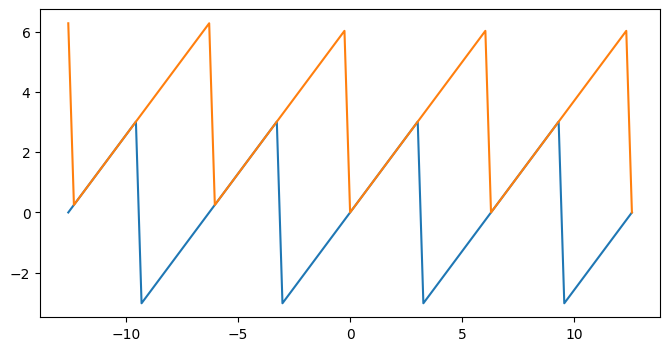

In [46]:
def angle_wrap(angle):
    return math.fmod(angle + math.pi, 2 * math.pi) + (-1 + 2 * (1 if angle + math.pi < 0 else 0)) * math.pi

def angle_wrap_2pi(angle):
    return math.fmod(angle, 2 * math.pi) if angle >= 0 else (2 * math.pi + math.fmod(angle, 2 * math.pi))

# point[0] == min_value, point[-1] == max_value
def uniform_range(min_value, max_value, num_points):
    return [min_value + i * (max_value - min_value) / (num_points - 1) for i in range(num_points)]

figure_size = (8, 4)
figure = plt.figure(figsize=figure_size)
ax = figure.gca()
test_range = uniform_range(-4 * math.pi, 4 * math.pi, 101)
ax.plot(test_range, [angle_wrap(i) for i in test_range])
ax.plot(test_range, [angle_wrap_2pi(i) for i in test_range])

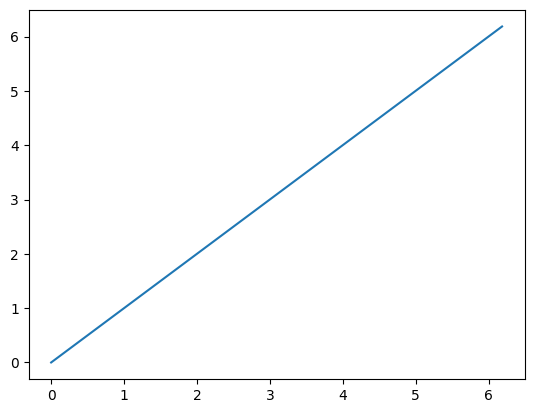

In [9]:
def atan2_2pi(y, x):
    return angle_wrap_2pi(math.atan2(y, x))

phi = [i / 64 * 2 * math.pi for i in range(64)]
x = [math.cos(angle) for angle in phi]
y = [math.sin(angle) for angle in phi]
phi_recalculated = [atan2_2pi(y, x) for x, y in zip(x, y)]
plt.plot(phi, phi_recalculated)

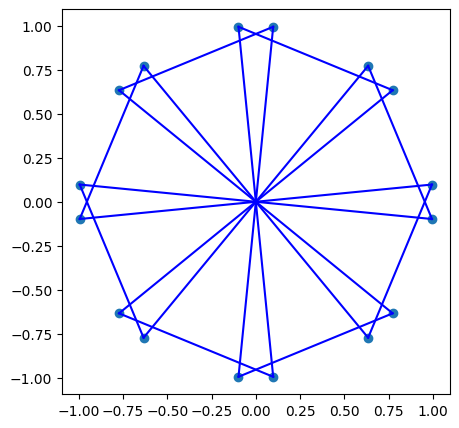

In [40]:
def uniform_range_split(num_ranges, min_range, max_range, margin):
    boundaries = uniform_range(min_range, max_range, num_ranges + 1)
    return [(boundaries[i] - margin, boundaries[i + 1] + margin) for i in range(num_ranges)]

figure_size = (5, 5)
figure = plt.figure(figsize=figure_size)
ax = figure.gca()

ranges = uniform_range_split(8, 0, 2 * math.pi, 2 * math.pi / 64)

outermost_points = []
for (range_min, range_max) in ranges:
    range_min_x = math.cos(range_min) 
    range_min_y = math.sin(range_min)
    range_max_x = math.cos(range_max)
    range_max_y = math.sin(range_max)
    outermost_points.append((range_min_x, range_min_y))
    outermost_points.append((range_max_x, range_max_y))
    plt.plot([0, range_min_x], [0, range_min_y], c='blue')
    plt.plot([0, range_max_x], [0, range_max_y], c='blue')
    plt.plot([range_min_x, range_max_x], [range_min_y, range_max_y], c='blue')
plt.scatter([i[0] for i in outermost_points], [i[1] for i in outermost_points])

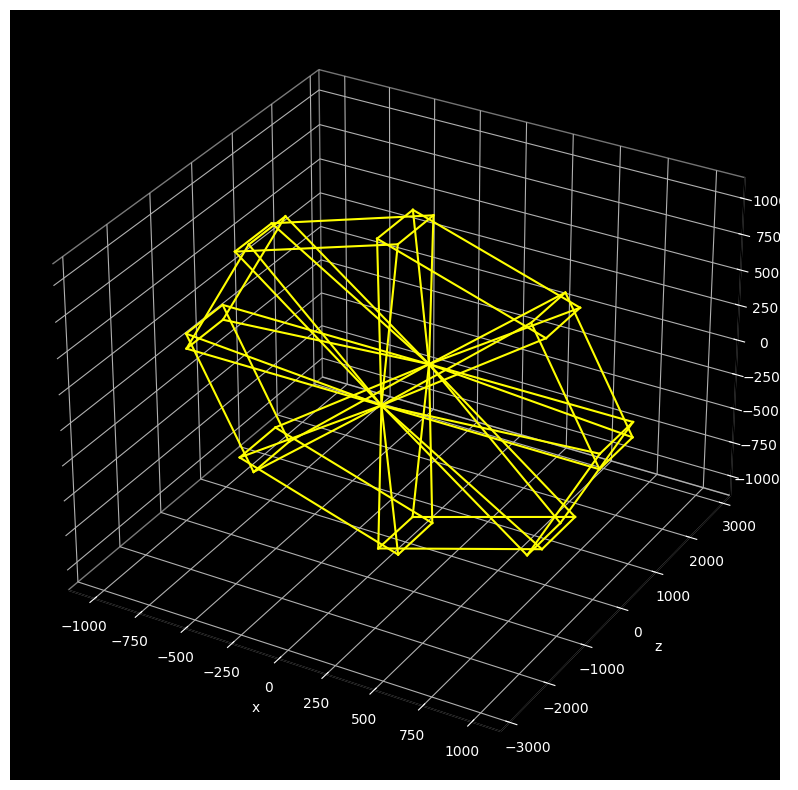

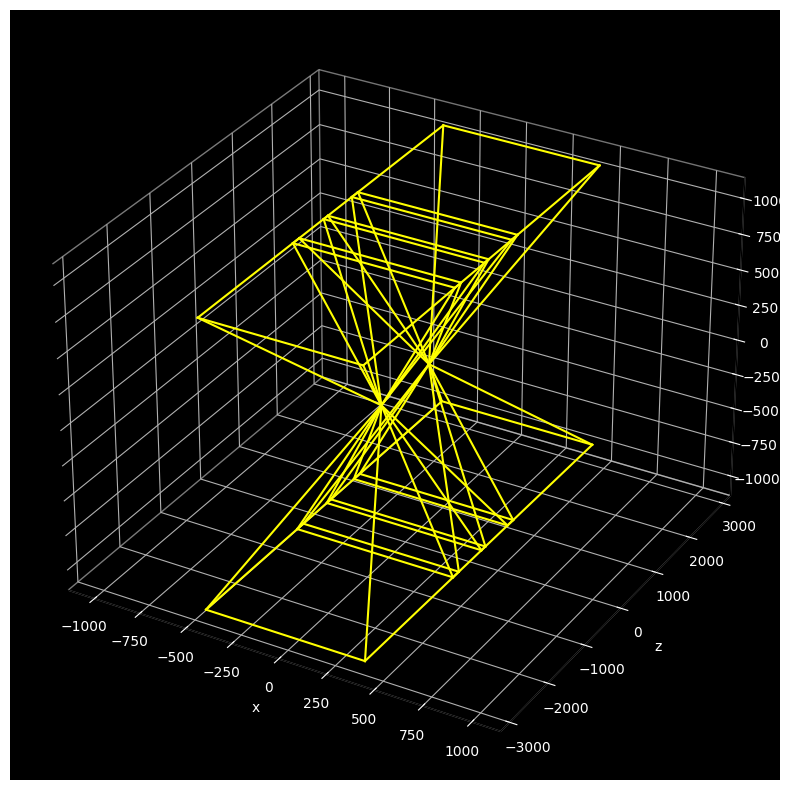

In [42]:
z_ranges = [(angle_wrap_2pi(i[0]), angle_wrap_2pi(i[1])) for i in uniform_range_split(8, 0, 2 * math.pi, 2 * math.pi / 128)]
wedges = [Wedge(z_range[0], z_range[1], 3 * 1 / 8 * math.pi, 5 * 1 / 8 * math.pi, 2 * 0.2 * DetectorProperties.max_abs_z) for z_range in z_ranges]

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)

x_ranges = uniform_range_split(4, 8 / 64 * math.pi, 56 / 64 * math.pi, 2 * math.pi / 128)
x_ranges.extend(uniform_range_split(4, 72 / 64 * math.pi, 120 / 64 * math.pi, 2 * math.pi / 128))

wedges = [Wedge(3 * 1 / 8 * math.pi, 5 * 1 / 8 * math.pi, x_range[0], x_range[1], 2 * 0.2 * DetectorProperties.max_abs_z) for x_range in x_ranges]

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)

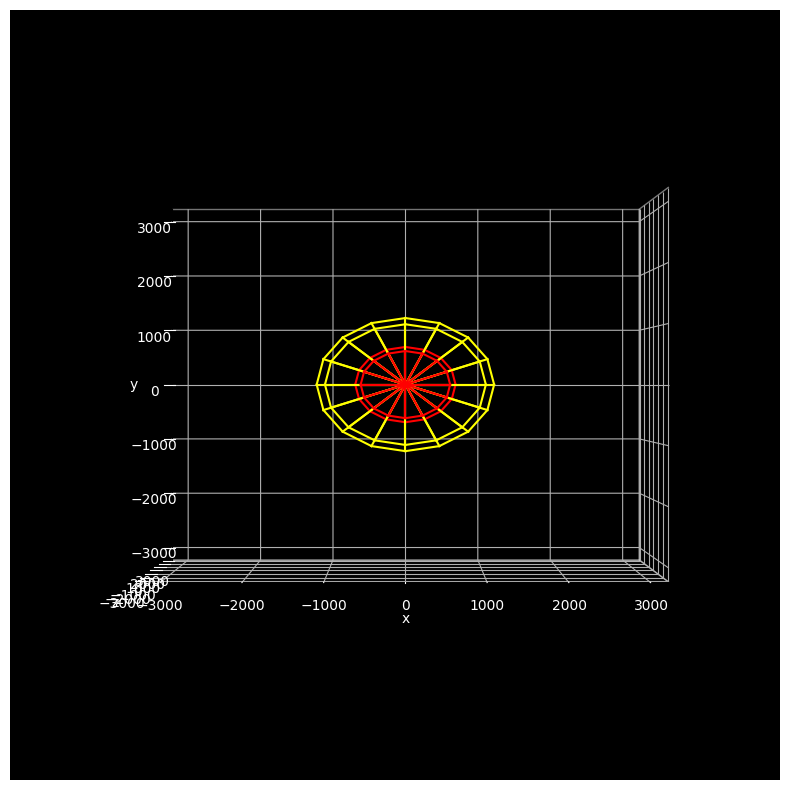

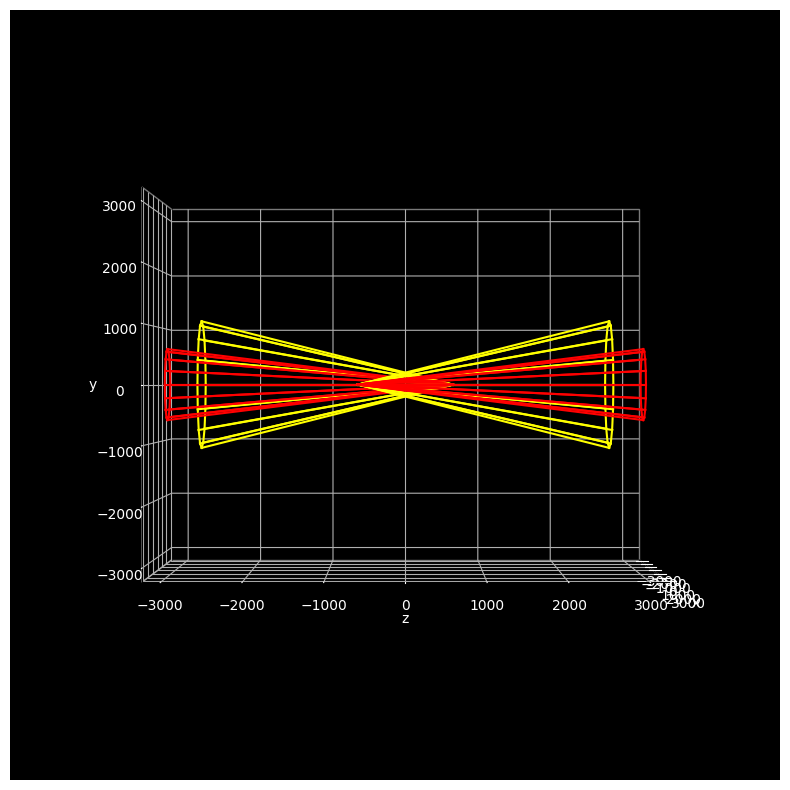

In [57]:
class PoleRegion:
    def __init__(self, x_angle, interaction_region_width):
        self.x_angle = x_angle
        self.interaction_region_width = interaction_region_width

    def get_outermost_points(self, num_points):
        x_plane_direction_z = math.cos(self.x_angle)
        x_plane_direction_y = math.sin(self.x_angle)

        x_plane_scale_to_z_limit = abs(x_plane_direction_z) / DetectorProperties.max_abs_z
        x_plane_scale_to_y_limit = abs(x_plane_direction_y) / DetectorProperties.max_abs_xy
        scale = 1 / max(x_plane_scale_to_z_limit, x_plane_scale_to_y_limit)

        points = []
        for z_angle in [i / num_points * 2 * math.pi for i in range(num_points)]:
            points.append({
                'x': x_plane_direction_y * math.cos(z_angle) * scale,
                'y': x_plane_direction_y * math.sin(z_angle) * scale,
                'z': x_plane_direction_z * scale
            })
        return points
    
    def get_interaction_region_z(self):
        return (1 if self.x_angle > math.pi / 2 else -1) * self.interaction_region_width / 2

def plot_pole_region(figure, ax, region, num_rays=16, color='yellow'):
    outermost_points = region.get_outermost_points(num_rays)
    interaction_region_z = region.get_interaction_region_z()

    xs = []
    ys = []
    zs = []
    for point in outermost_points:
        xs.append([0, point['x']])
        ys.append([0, point['y']])
        zs.append([interaction_region_z, point['z']])

    for i in range(len(outermost_points) - 1):
        xs.append([outermost_points[i]['x'], outermost_points[i + 1]['x']])
        ys.append([outermost_points[i]['y'], outermost_points[i + 1]['y']])
        zs.append([outermost_points[i]['z'], outermost_points[i + 1]['z']])

    xs.append([outermost_points[-1]['x'], outermost_points[0]['x']])
    ys.append([outermost_points[-1]['y'], outermost_points[0]['y']])
    zs.append([outermost_points[-1]['z'], outermost_points[0]['z']])

    for i in range(len(xs)):
        ax.plot(xs[i], zs[i], ys[i], color=color)

pole_region = PoleRegion(56 / 64 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z)
pole_region2 = PoleRegion(60 / 64 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z)
pole_region3 = PoleRegion(8 / 64 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z)
pole_region4 = PoleRegion(4 / 64 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z)

figure, ax = get_3d_plot_figure(figure_size=(10, 10), keep_aspect_ratio=True)
ax.view_init(elev=0, azim=270, roll=0)
num_rays = 16
plot_pole_region(figure, ax, pole_region, num_rays=num_rays)
plot_pole_region(figure, ax, pole_region2, num_rays=num_rays, color="red")
plot_pole_region(figure, ax, pole_region3, num_rays=num_rays)
plot_pole_region(figure, ax, pole_region4, num_rays=num_rays, color="red")

figure, ax = get_3d_plot_figure(figure_size=(10, 10), keep_aspect_ratio=True)
ax.view_init(elev=0, azim=0, roll=0)
num_rays = 16
plot_pole_region(figure, ax, pole_region, num_rays=num_rays)
plot_pole_region(figure, ax, pole_region2, num_rays=num_rays, color="red")
plot_pole_region(figure, ax, pole_region3, num_rays=num_rays)
plot_pole_region(figure, ax, pole_region4, num_rays=num_rays, color="red")


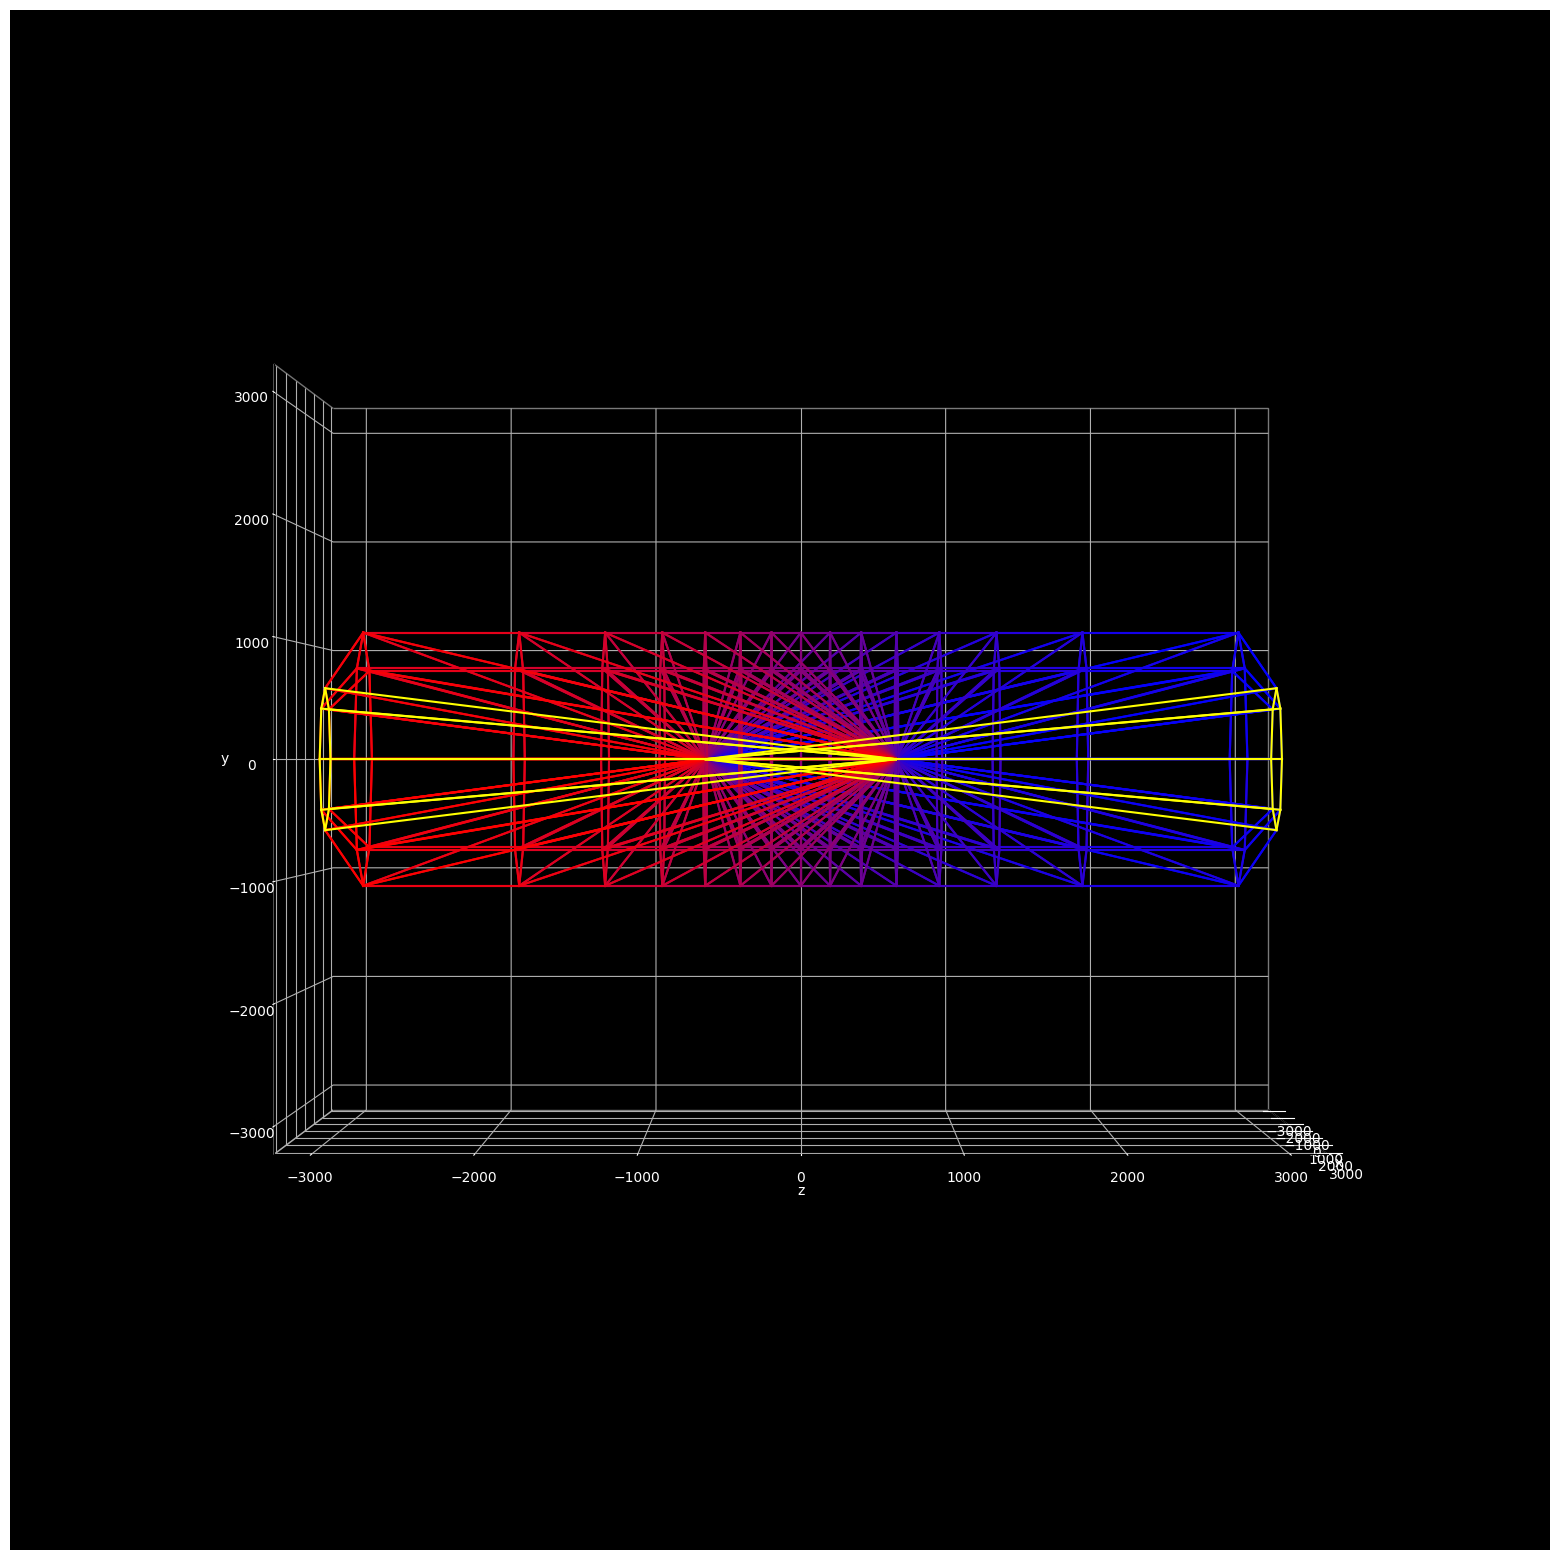

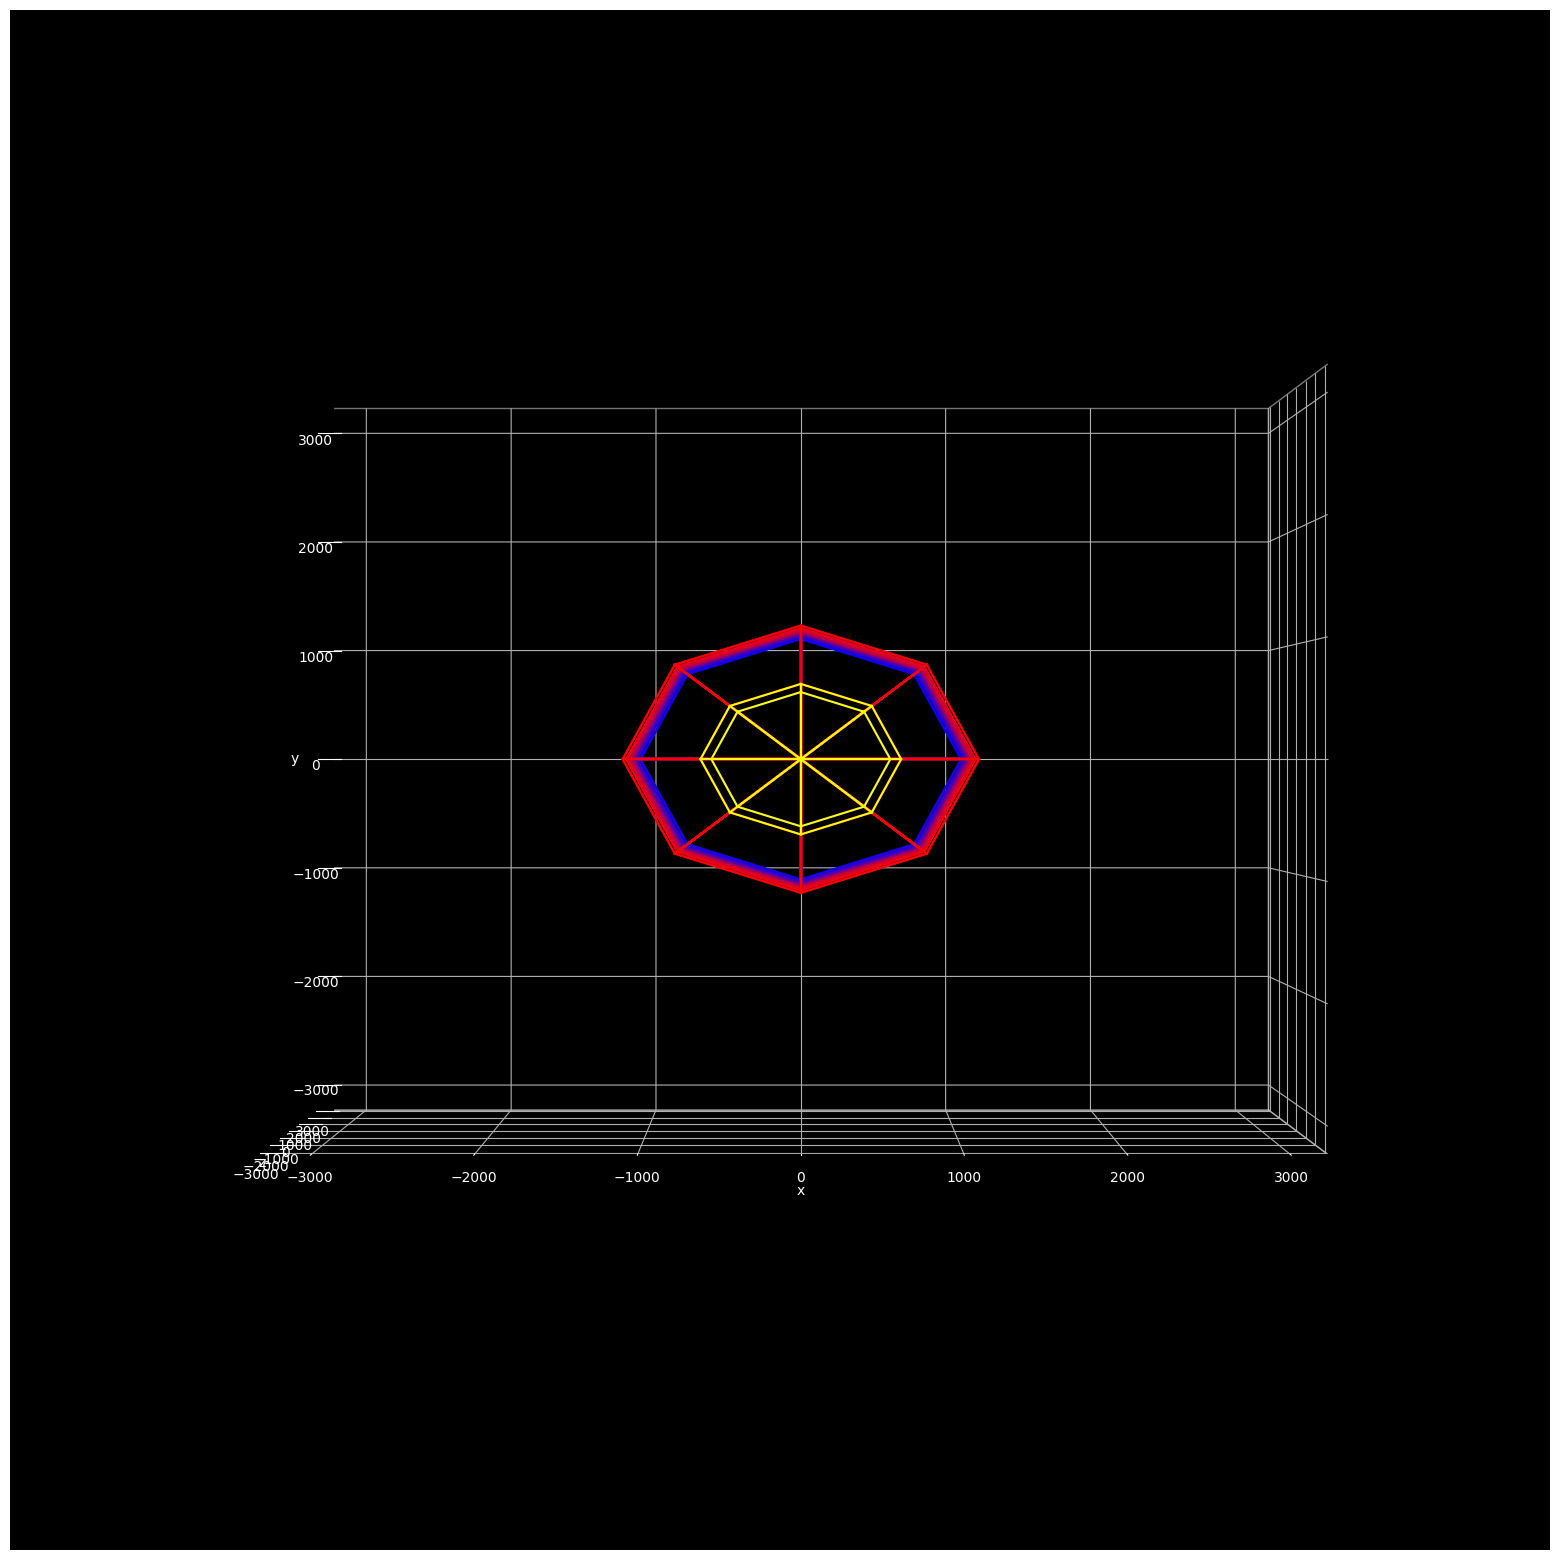

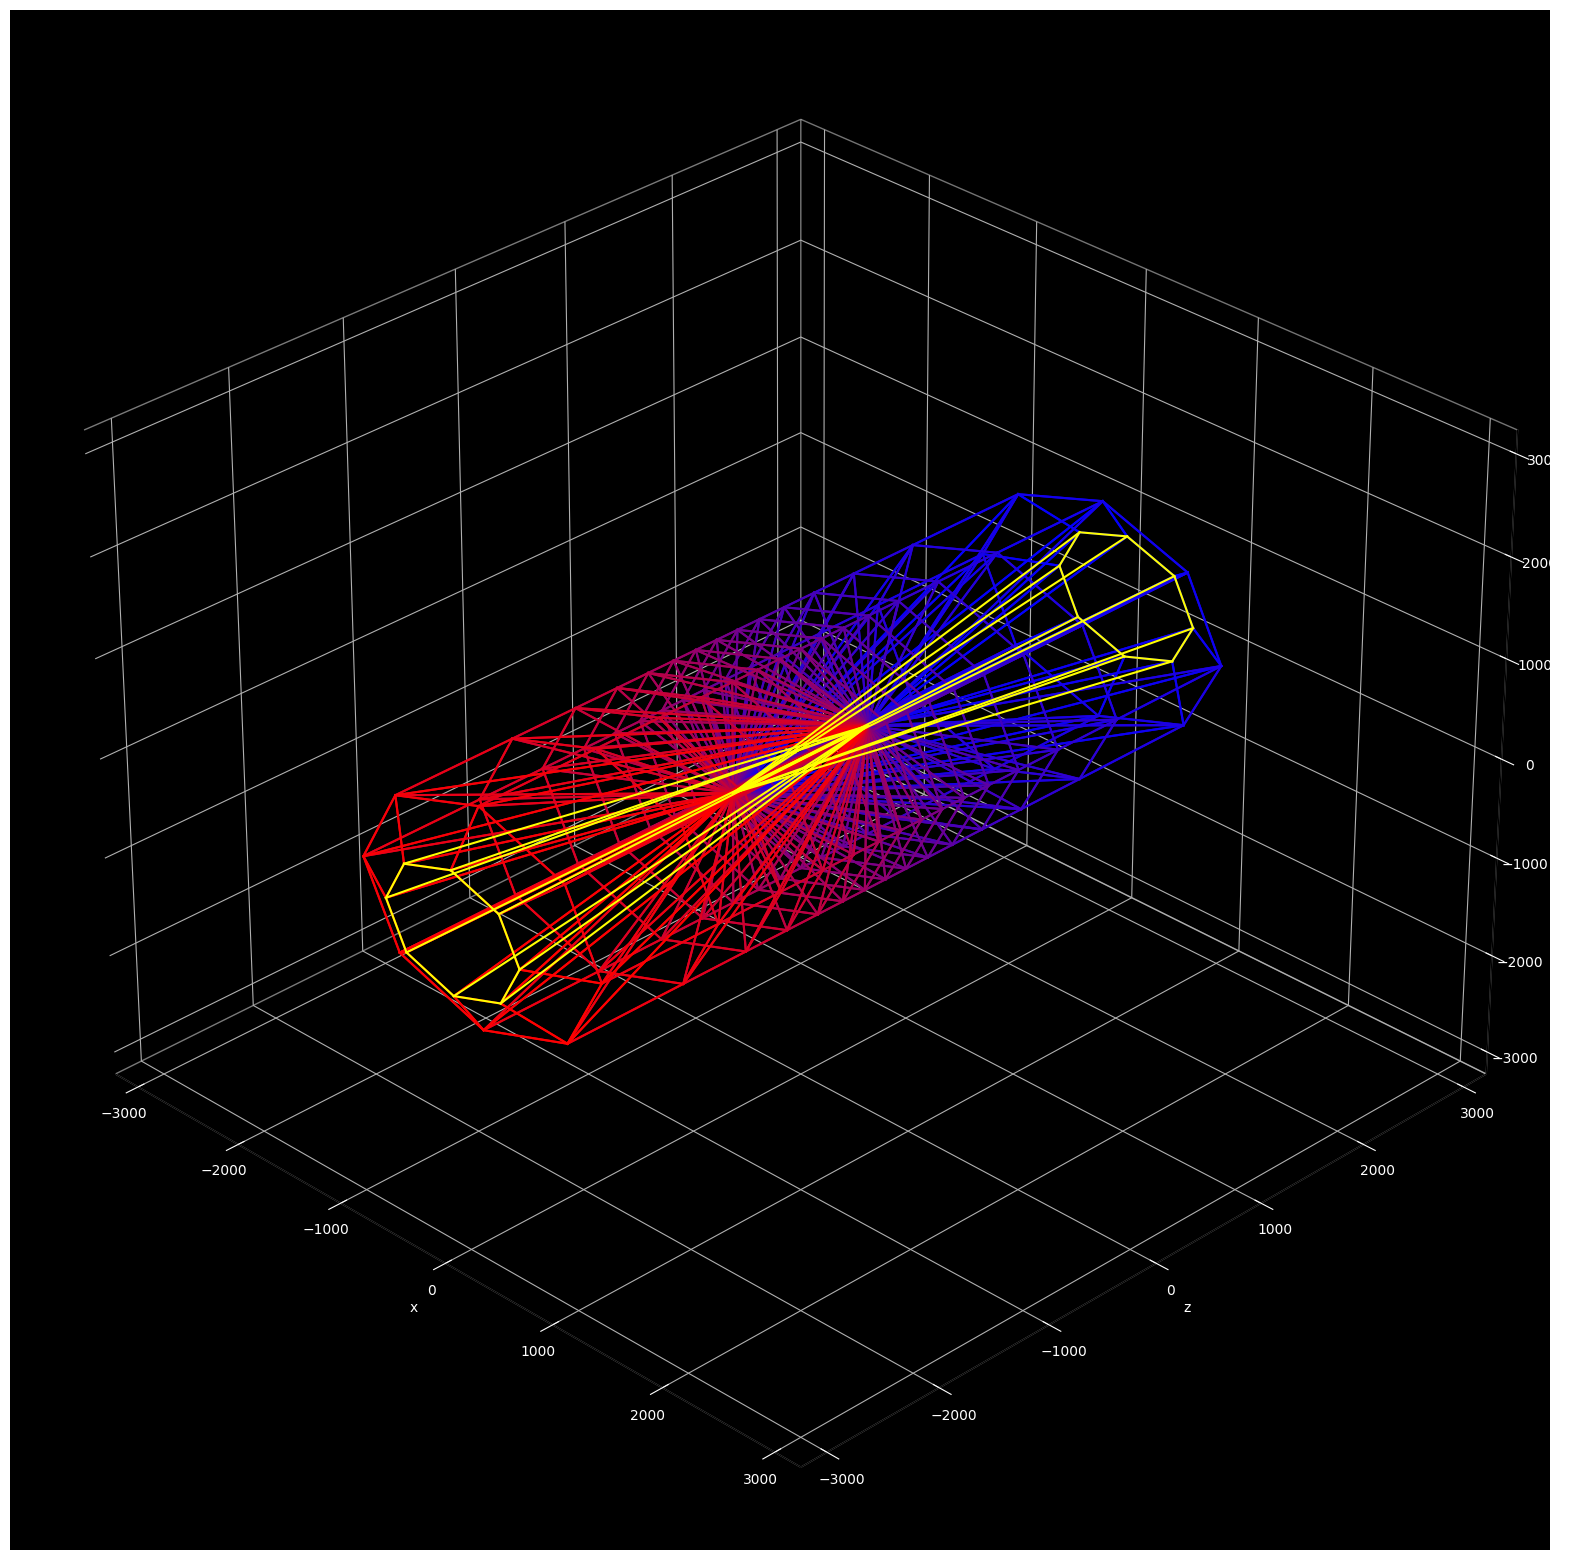

In [72]:
def get_wedges(num_z_ranges, num_x_ranges, min_x_angle, interaction_region_width, margin=0):
    z_ranges = [(angle_wrap_2pi(i[0]), angle_wrap_2pi(i[1])) for i in uniform_range_split(num_z_ranges, 0, 2 * math.pi, margin)]
    x_ranges = uniform_range_split(num_x_ranges, min_x_angle, math.pi - min_x_angle, margin)

    wedges = []
    for x_range in x_ranges:
        for z_range in z_ranges:
            wedges.append(Wedge(z_range[0], z_range[1], x_range[0], x_range[1], interaction_region_width))
    return wedges

def get_pole_regions(min_x_angle, interaction_region_width, margin=0):
    return [
        PoleRegion(min_x_angle + margin, interaction_region_width),
        PoleRegion(math.pi - min_x_angle - margin, interaction_region_width)
    ]

def get_wedges_and_pole_regions(num_z_ranges, num_x_ranges, min_x_angle, interaction_region_width, margin=0):
    return get_wedges(num_z_ranges, num_x_ranges, min_x_angle, interaction_region_width, margin), get_pole_regions(min_x_angle, interaction_region_width, margin)

num_z_ranges = 8
num_x_ranges = 16
min_x_angle = 4 / 64 * math.pi
interaction_region_width = 2 * 0.2 * DetectorProperties.max_abs_z
wedges, pole_regions = get_wedges_and_pole_regions(num_z_ranges, num_x_ranges, min_x_angle, interaction_region_width)

perspectives = []
perspectives.append({'elev': 0, 'azim': 0, 'roll': 0})
perspectives.append({'elev': 0, 'azim': 270, 'roll': 0})
perspectives.append({'elev': 30, 'azim': -45, 'roll': 0})
for perspective in perspectives:
    figure, ax = get_3d_plot_figure(figure_size=(20, 20), keep_aspect_ratio=True)
    ax.view_init(elev=perspective['elev'], azim=perspective['azim'], roll=perspective['roll'])
    for i in range(len(wedges)):
        red = (i / (len(wedges) - 1))
        blue = 1 - red
        plot_wedge_lines(figure, ax, wedges[i], color=(red, 0, blue))
    for pole_region in pole_regions:
        plot_pole_region(figure, ax, pole_region, num_rays=num_z_ranges, color='yellow')

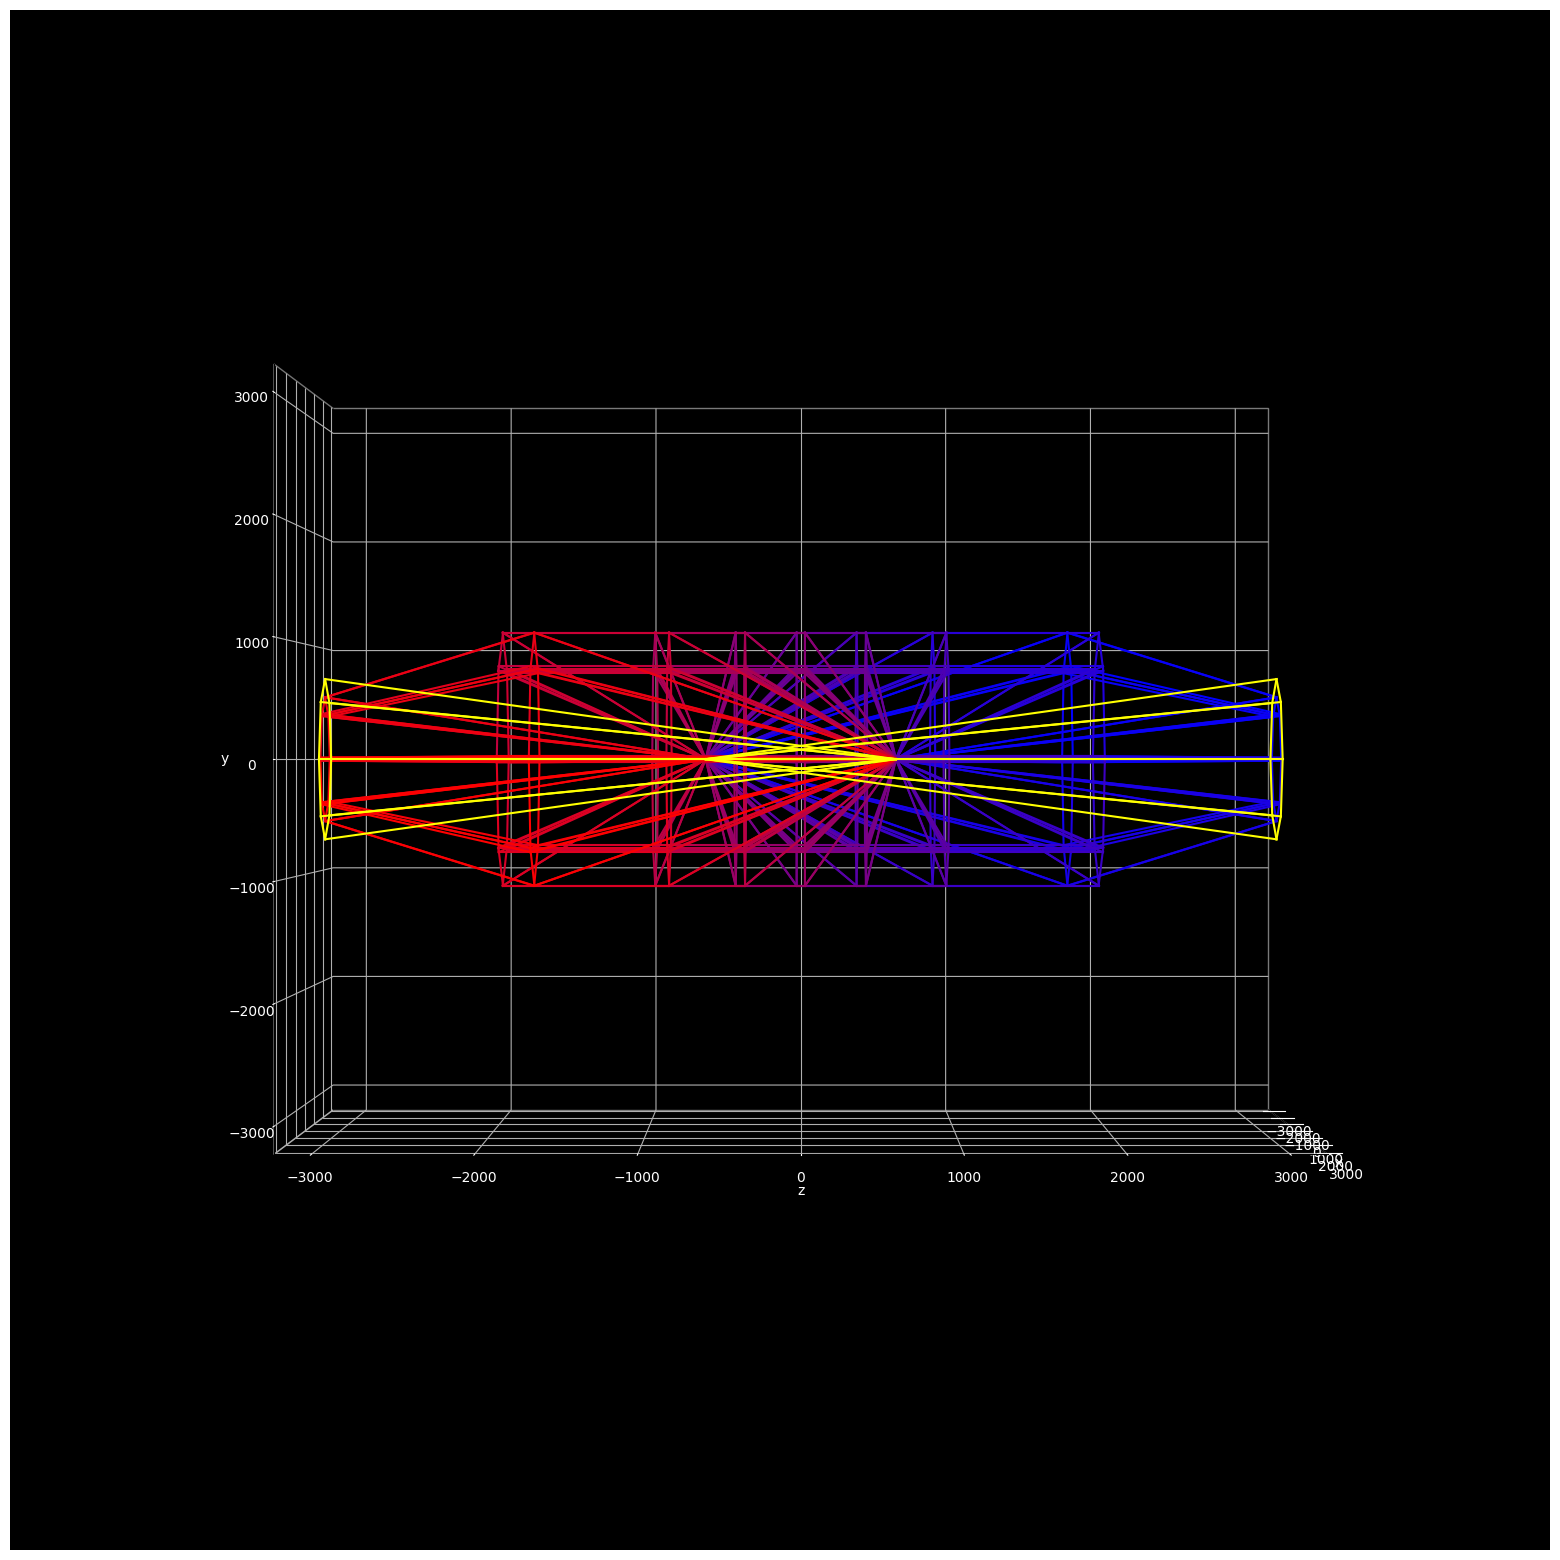

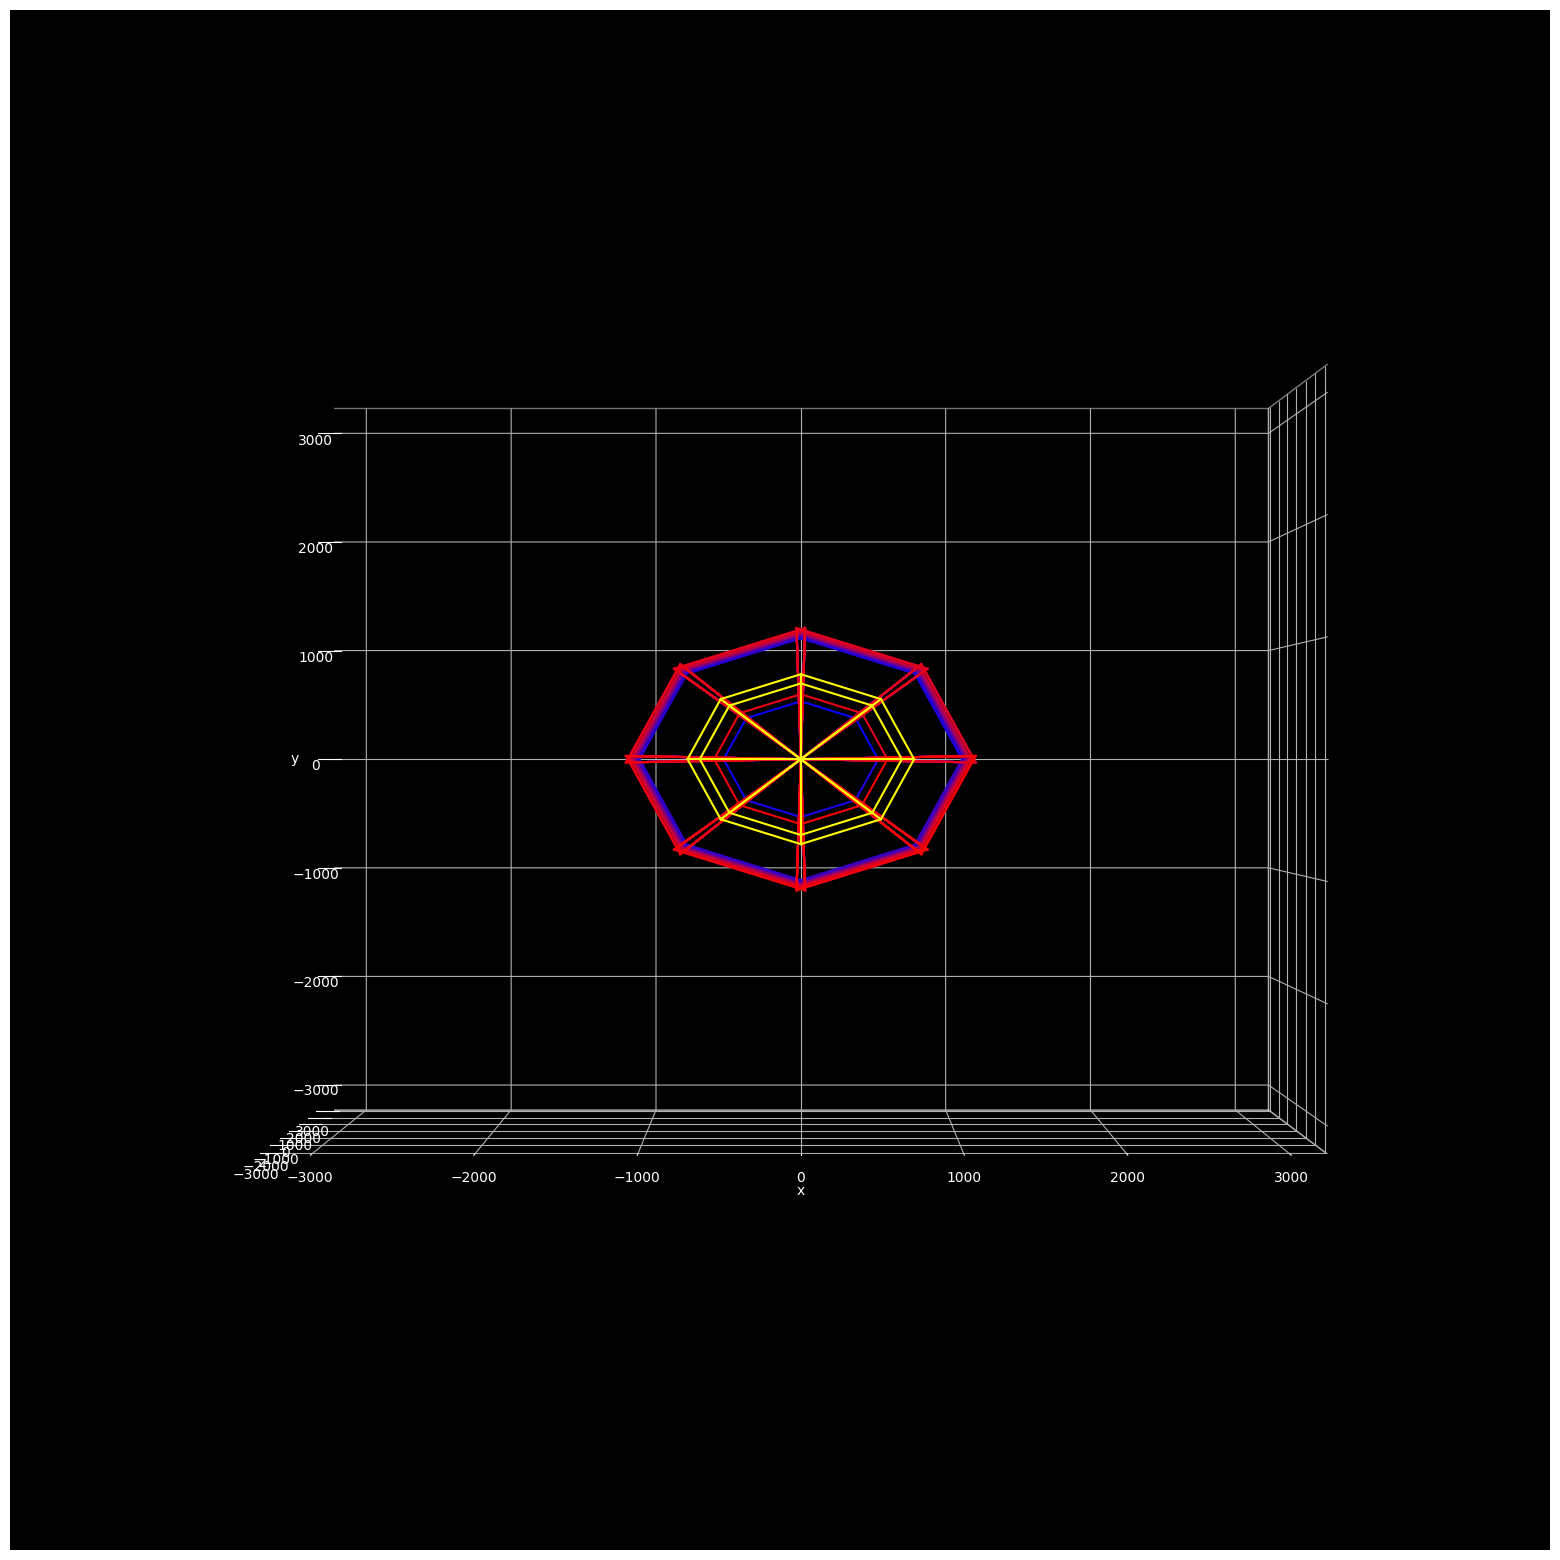

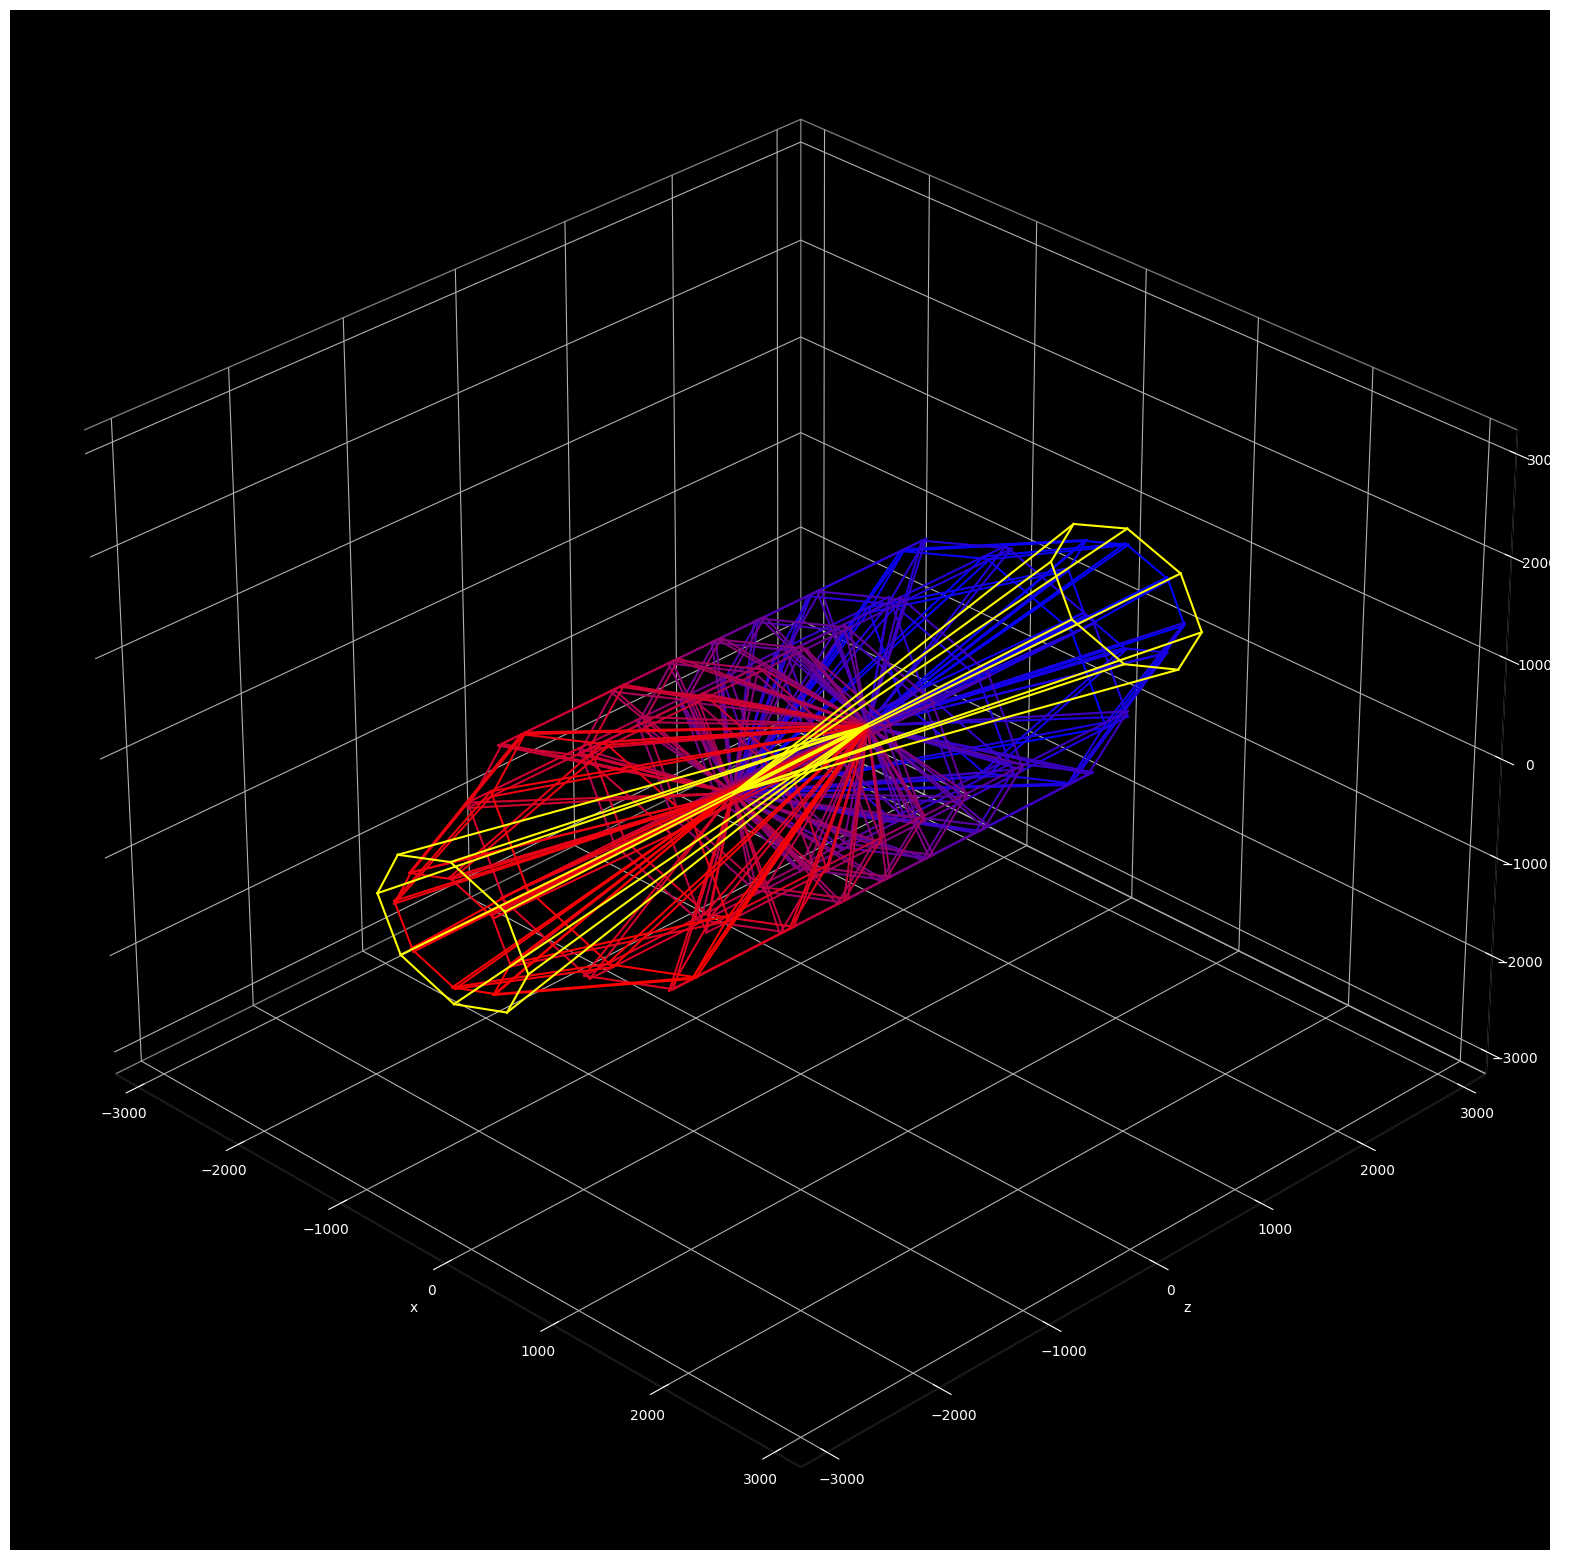

In [74]:
def get_wedges_and_pole_regions(num_z_ranges, num_x_ranges, min_x_angle, interaction_region_width, margin=0):
    return get_wedges(num_z_ranges, num_x_ranges, min_x_angle, interaction_region_width, margin), get_pole_regions(min_x_angle, interaction_region_width, margin)

num_z_ranges = 8
num_x_ranges = 8
min_x_angle = 4 / 64 * math.pi
interaction_region_width = 2 * 0.2 * DetectorProperties.max_abs_z
margin = 2 / 256 * math.pi
wedges, pole_regions = get_wedges_and_pole_regions(num_z_ranges, num_x_ranges, min_x_angle, interaction_region_width, margin)

perspectives = []
perspectives.append({'elev': 0, 'azim': 0, 'roll': 0})
perspectives.append({'elev': 0, 'azim': 270, 'roll': 0})
perspectives.append({'elev': 30, 'azim': -45, 'roll': 0})
for perspective in perspectives:
    figure, ax = get_3d_plot_figure(figure_size=(20, 20), keep_aspect_ratio=True)
    ax.view_init(elev=perspective['elev'], azim=perspective['azim'], roll=perspective['roll'])
    for i in range(len(wedges)):
        red = (i / (len(wedges) - 1))
        blue = 1 - red
        plot_wedge_lines(figure, ax, wedges[i], color=(red, 0, blue))
    for pole_region in pole_regions:
        plot_pole_region(figure, ax, pole_region, num_rays=num_z_ranges, color='yellow')

# TODO: fix all below

Yellow points:  228
Unassigned points:  0 (Should ALWAYS be 0)


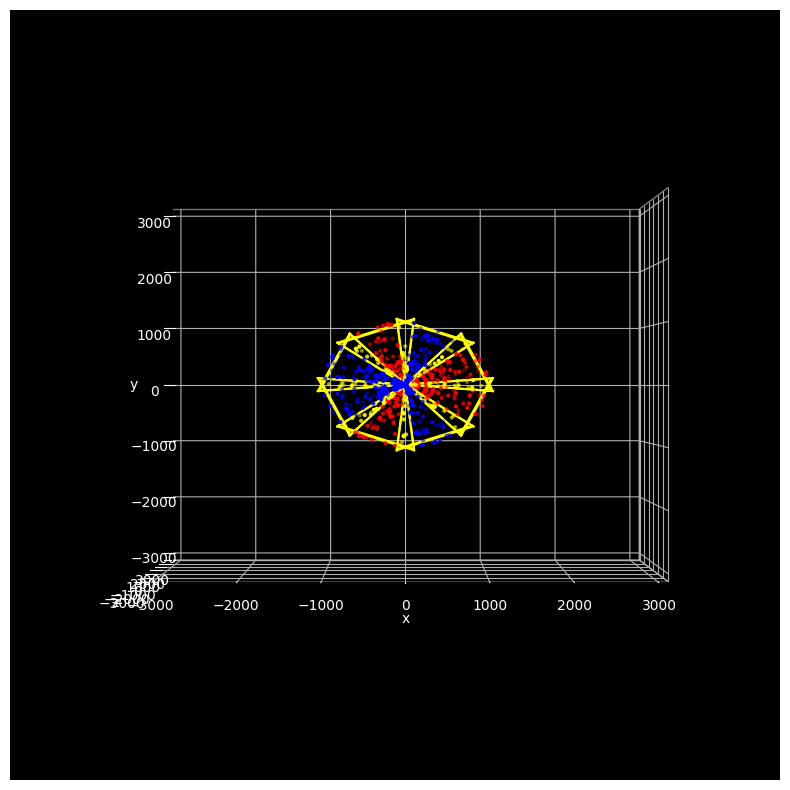

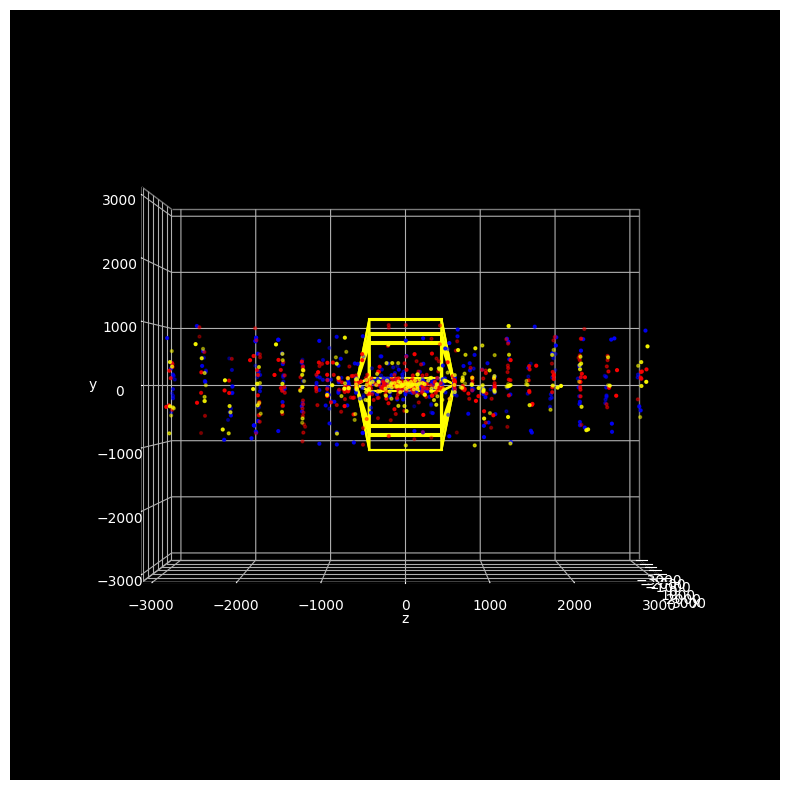

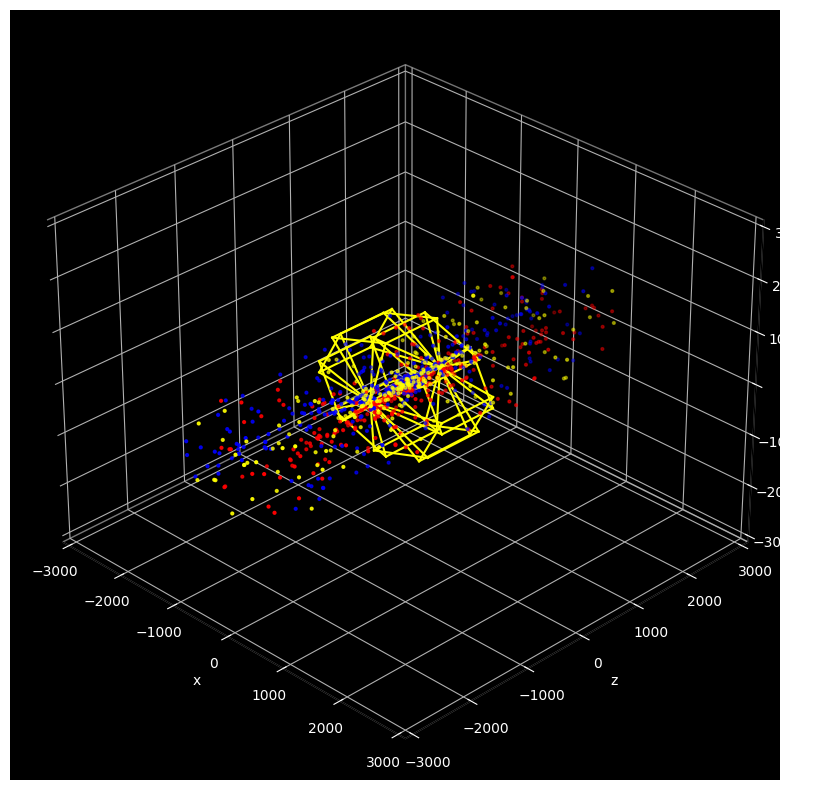

In [14]:
def point_in_wedge_z_angle(point, wedge):
    z_angle = abs(math.atan2(point['y'], point['x']))
    if wedge.z_angle_min < wedge.z_angle_max and not (wedge.z_angle_min <= z_angle and z_angle <= wedge.z_angle_max):
        return False

    if wedge.z_angle_min > wedge.z_angle_max and not ((wedge.z_angle_min <= z_angle) or (z_angle <= wedge.z_angle_max)):
        return False

    return True

# Remember to test with margin = 0 and large margin
margin = 8 / 256 * math.pi
num_z_ranges = 8
z_ranges = [(angle_wrap_2pi(i[0]), angle_wrap_2pi(i[1])) for i in uniform_range_split(num_z_ranges, 0, 2 * math.pi, margin)]
wedges = []
for z_range in z_ranges:
    wedges.append(Wedge(z_range[0], z_range[1], 3 / 8 * math.pi, 5 / 8 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z))

test_points = random.sample(points, 1000)
red_points = []
blue_points = []
for i in range(len(wedges)):
    points_in_wedge = [point for point in test_points if point_in_wedge_z_angle(point, wedges[i])]
    if i % 2 == 0:
        red_points.extend(points_in_wedge)
    else:
        blue_points.extend(points_in_wedge)

yellow_points = [point for point in test_points if point in red_points and point in blue_points]
red_points = [point for point in red_points if point not in yellow_points]
blue_points = [point for point in blue_points if point not in yellow_points]
print("Yellow points: ", len(yellow_points))

unassigned_points = [point for point in test_points if point not in red_points and point not in blue_points and point not in yellow_points]
print("Unassigned points: ", len(unassigned_points), "(Should ALWAYS be 0)")

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=270, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=0, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=30, azim=-45, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

Yellow points:  547
Unassigned points:  161 (Should be 0 for non-pole regions)


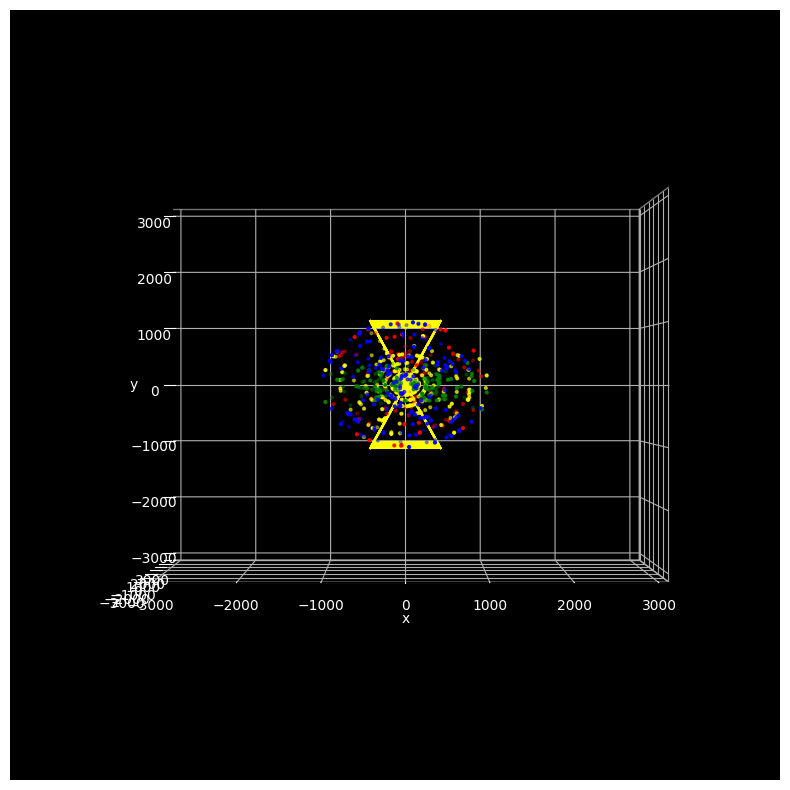

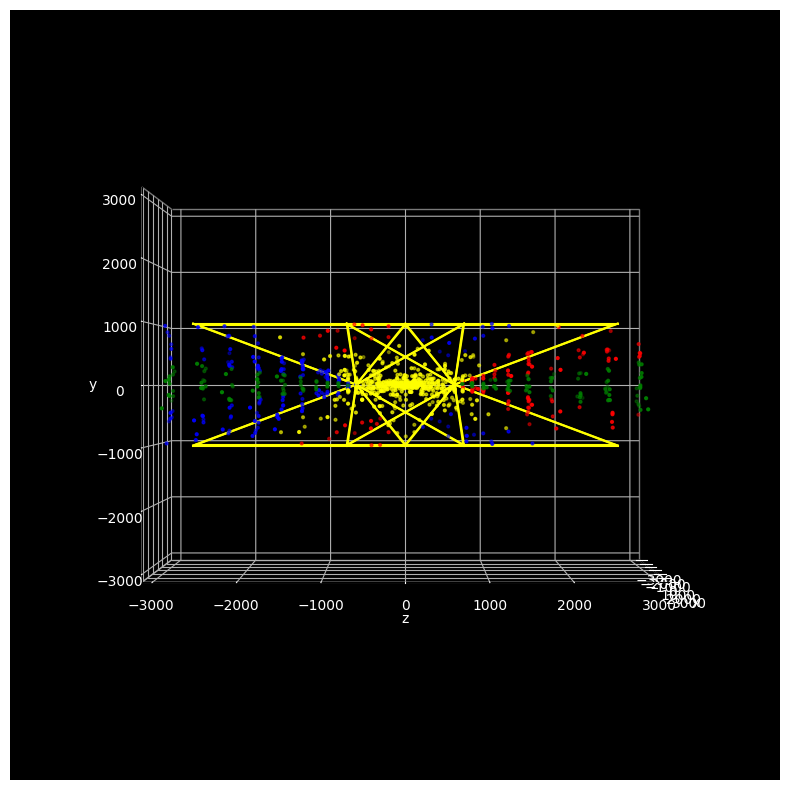

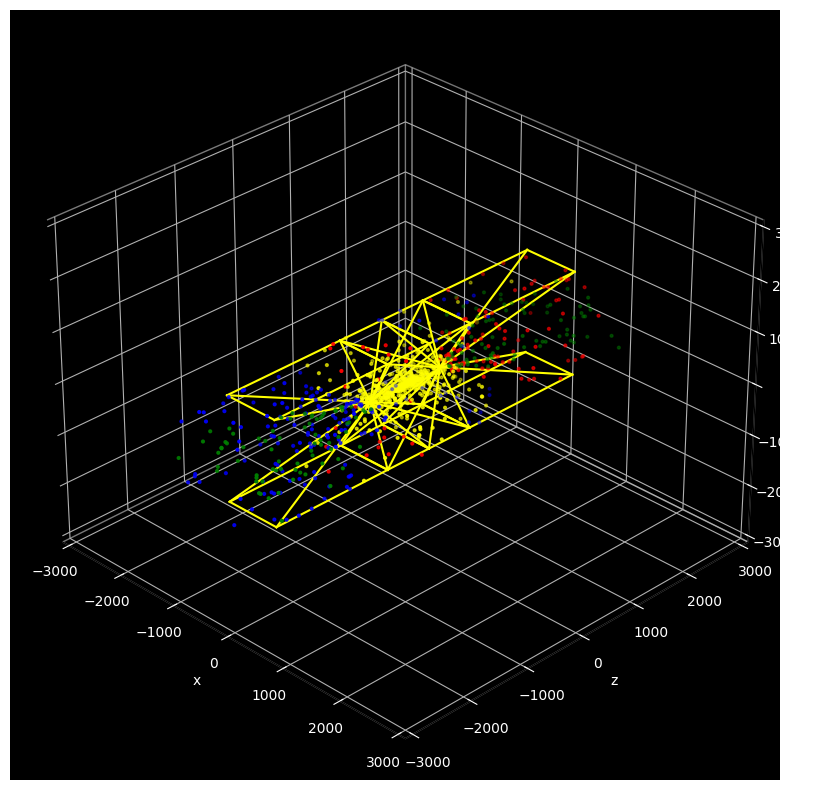

In [15]:
def point_in_wedge_x_angle(point, wedge):
    def get_boundary_yz(x_angle):
        y = math.sin(x_angle)
        z = math.cos(x_angle)
        ray_scale = 1 / max(abs(y), abs(z))
        y *= ray_scale * Wedge.point_max_abs_y
        z *= ray_scale * Wedge.point_max_abs_z
        return y, z

    interaction_region_shift = wedge.interaction_region_width / 2 

    # Min angle check
    boundary_y, boundary_z = get_boundary_yz(wedge.x_angle_min)
    boundary_x_angle = math.atan2(boundary_y, boundary_z - interaction_region_shift)
    point_x_angle = math.atan2(point['y'], point['z'] - interaction_region_shift)
    if not (abs(boundary_x_angle) <= abs(point_x_angle)):
        return False

    # Max angle check
    boundary_y, boundary_z = get_boundary_yz(wedge.x_angle_max)
    boundary_x_angle = math.atan2(boundary_y, boundary_z + interaction_region_shift)
    point_x_angle = math.atan2(point['y'], point['z'] + interaction_region_shift)
    if not (abs(boundary_x_angle) >= abs(point_x_angle)):
        return False
        
    return True
        

# Remember to test with margin = 0 and large margin
margin = 0 / 256 * math.pi
num_x_ranges = 4
x_ranges = uniform_range_split(num_x_ranges, 8 / 64 * math.pi, 56 / 64 * math.pi, margin)
x_ranges.extend(uniform_range_split(num_x_ranges, 72 / 64 * math.pi, 120 / 64 * math.pi, margin))
wedges = []
for x_range in x_ranges:
    wedges.append(Wedge(3 / 8 * math.pi, 5 / 8 * math.pi, x_range[0], x_range[1], 2 * 0.2 * Wedge.point_max_abs_z))

test_points = random.sample(points, 1000)
red_points = []
blue_points = []
for i in range(len(wedges)):
    points_in_wedge = [point for point in test_points if point_in_wedge_x_angle(point, wedges[i])]
    if i % 2 == 0:
        red_points.extend(points_in_wedge)
    else:
        blue_points.extend(points_in_wedge)

yellow_points = [point for point in test_points if point in red_points and point in blue_points]
red_points = [point for point in red_points if point not in yellow_points]
blue_points = [point for point in blue_points if point not in yellow_points]
print("Yellow points: ", len(yellow_points))

unassigned_points = [point for point in test_points if point not in red_points and point not in blue_points and point not in yellow_points]
print("Unassigned points: ", len(unassigned_points), "(Should be 0 for non-pole regions)")

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=270, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=0, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=30, azim=-45, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')


Yellow points:  129
Unassigned points:  479 (Should be 0 for non-pole regions)


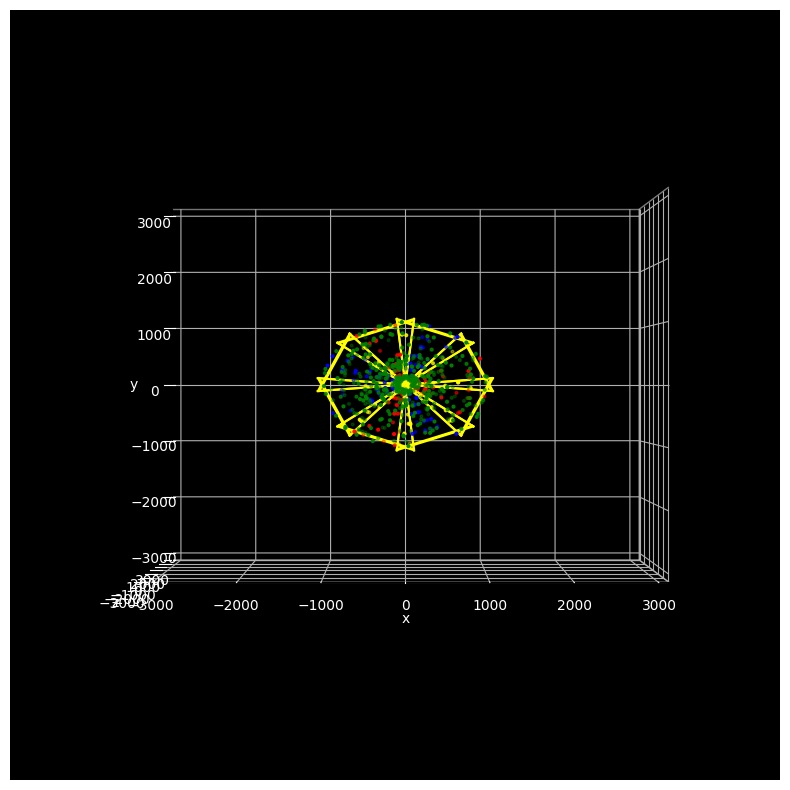

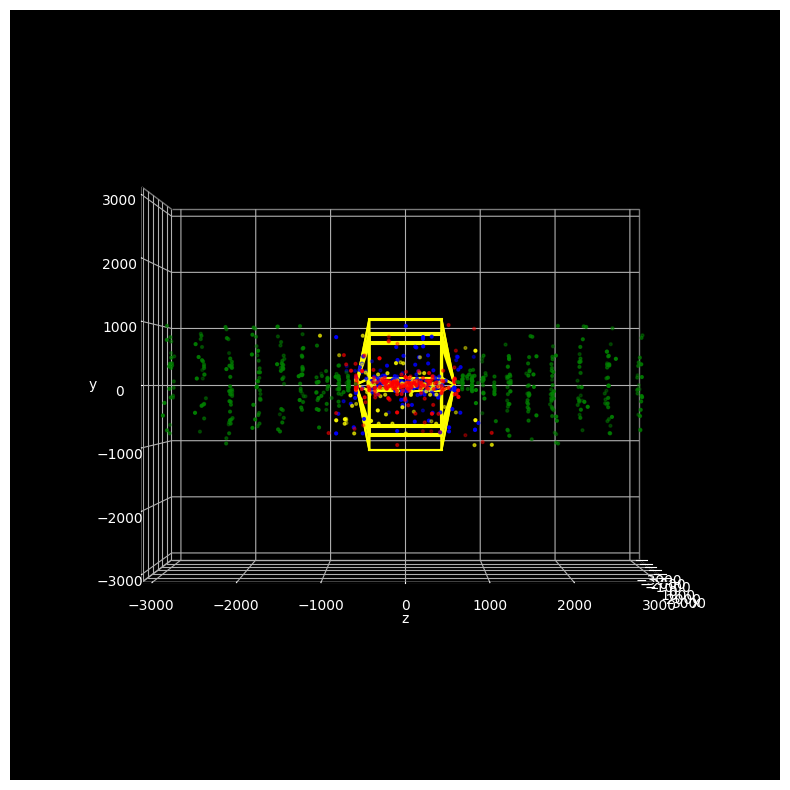

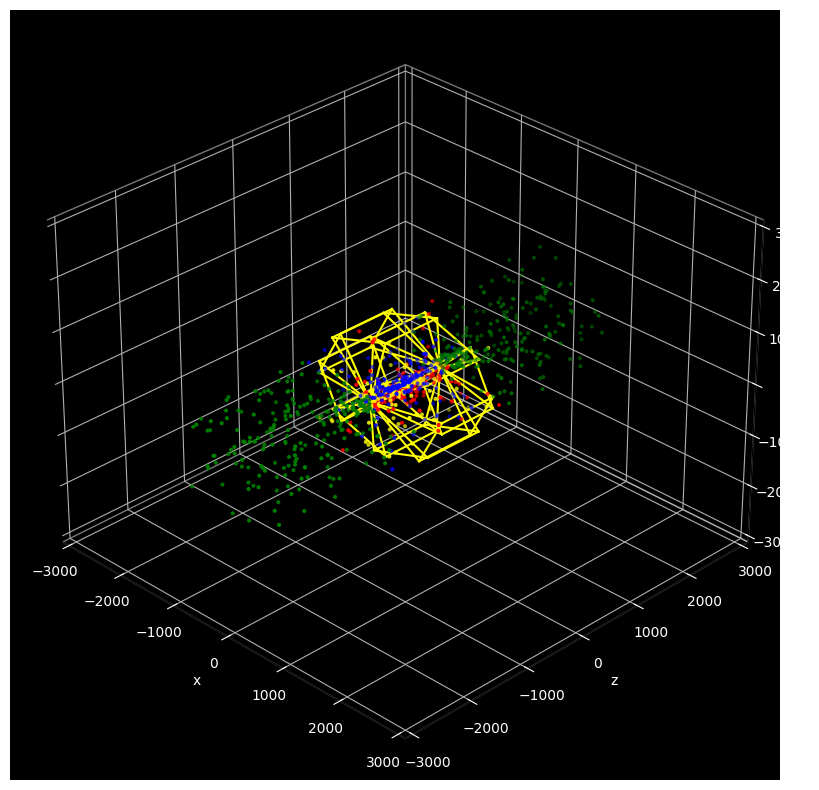

In [16]:
def point_in_wedge(point, wedge):
    return point_in_wedge_z_angle(point, wedge) and point_in_wedge_x_angle(point, wedge)
    # return  point_in_wedge_x_angle(point, wedge)
        

# # Remember to test with margin = 0 and large margin
# margin = 0 / 256 * math.pi
# num_x_ranges = 4
# x_ranges = uniform_range_split(num_x_ranges, 8 / 64 * math.pi, 56 / 64 * math.pi, margin)
# x_ranges.extend(uniform_range_split(num_x_ranges, 72 / 64 * math.pi, 120 / 64 * math.pi, margin))
# wedges = []
# for x_range in x_ranges:
#     wedges.append(Wedge(3 / 8 * math.pi, 5 / 8 * math.pi, x_range[0], x_range[1], 2 * 0.2 * Wedge.point_max_abs_z))

# Remember to test with margin = 0 and large margin
margin = 8 / 256 * math.pi
num_z_ranges = 8
z_ranges = [(angle_wrap_2pi(i[0]), angle_wrap_2pi(i[1])) for i in uniform_range_split(num_z_ranges, 0, 2 * math.pi, margin)]
wedges = []
for z_range in z_ranges:
    wedges.append(Wedge(z_range[0], z_range[1], 3 / 8 * math.pi, 5 / 8 * math.pi, 2 * 0.2 * Wedge.point_max_abs_z))

test_points = random.sample(points, 1000)
red_points = []
blue_points = []
for i in range(len(wedges)):
    points_in_wedge = [point for point in test_points if point_in_wedge(point, wedges[i])]
    if i % 2 == 0:
        red_points.extend(points_in_wedge)
    else:
        blue_points.extend(points_in_wedge)

yellow_points = [point for point in test_points if point in red_points and point in blue_points]
red_points = [point for point in red_points if point not in yellow_points]
blue_points = [point for point in blue_points if point not in yellow_points]
print("Yellow points: ", len(yellow_points))

unassigned_points = [point for point in test_points if point not in red_points and point not in blue_points and point not in yellow_points]
print("Unassigned points: ", len(unassigned_points), "(Should be 0 for non-pole regions)")

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=270, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=0, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=30, azim=-45, roll=0)
for wedge in wedges:
    plot_wedge_lines(figure, ax, wedge)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')


3.043918451602442 2.9585456286643557
3.043918451602442 1.5109286058021627
3.043918451602442 2.8881279126963797
3.043918451602442 2.9874119920112134
3.043918451602442 3.108322233199007
3.043918451602442 2.0356810797061295
3.043918451602442 3.0013953085652036
3.043918451602442 3.06283530698062
3.043918451602442 3.065032792688614
3.043918451602442 3.094260597992632
3.043918451602442 2.0001976952443568
3.043918451602442 0.5557402969505753
3.043918451602442 3.0650495386799026
3.043918451602442 2.687123481687996
3.043918451602442 0.4104296616714716
3.043918451602442 2.4007271919592714
3.043918451602442 0.3151727592944123
3.043918451602442 3.103246050998224
3.043918451602442 0.6276112453065659
3.043918451602442 3.012081285935679
3.043918451602442 3.053791994385855
3.043918451602442 3.1215847316993712
3.043918451602442 3.0808480992804212
3.043918451602442 3.0592918572457948
3.043918451602442 3.105740561201959
3.043918451602442 2.927529332097097
3.043918451602442 2.8692045498281273
3.0439184516

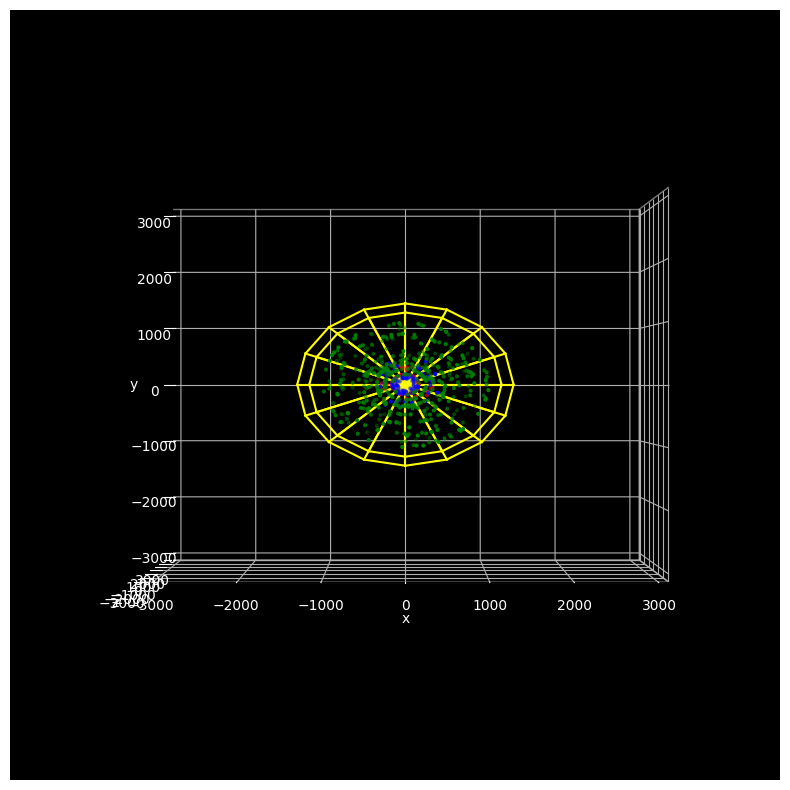

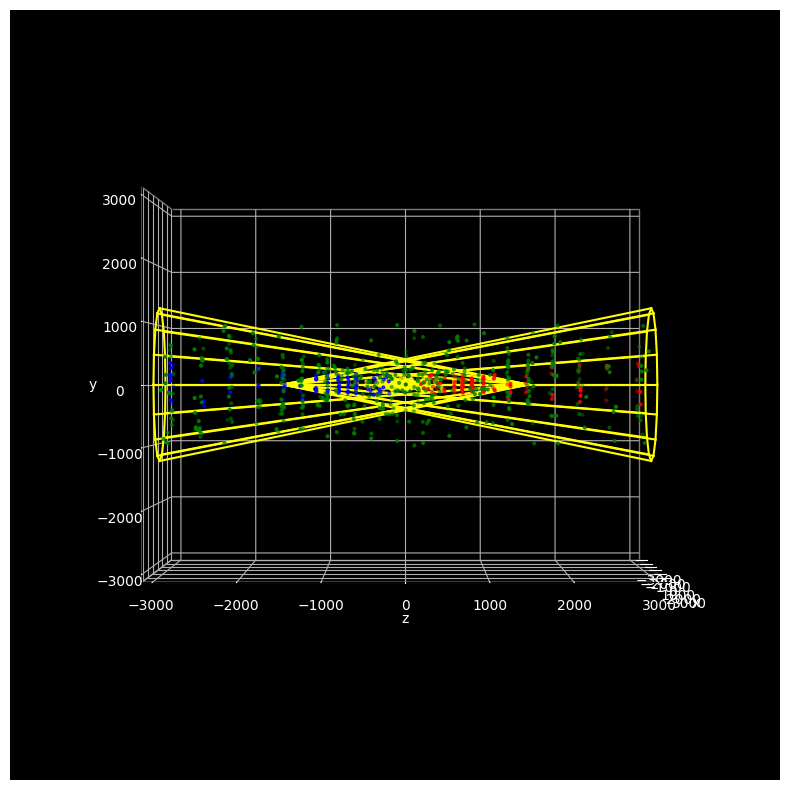

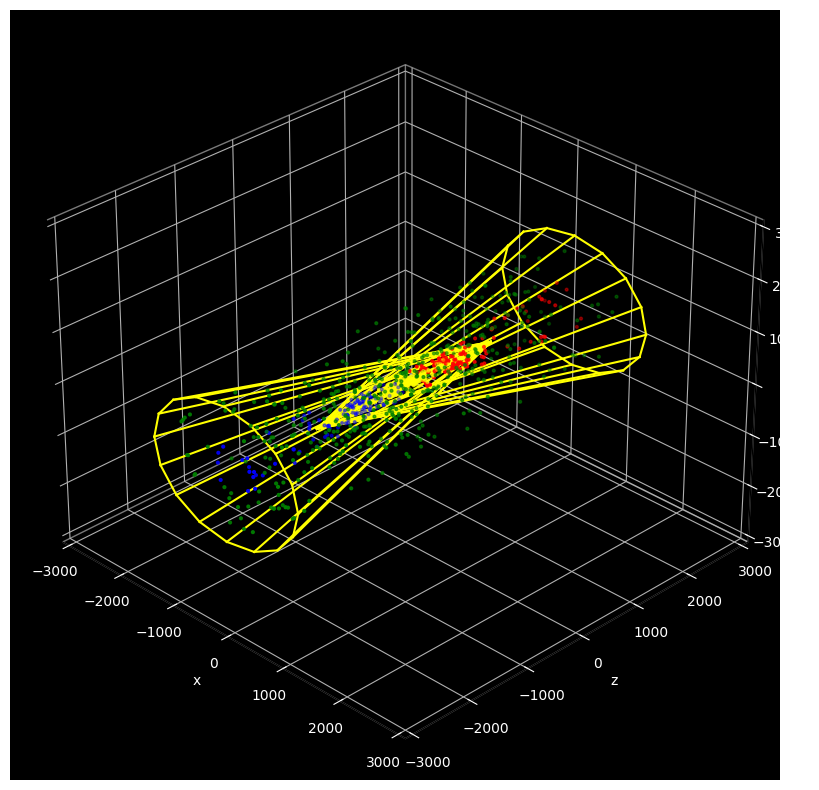

In [17]:
def point_in_pole_region(point, region):
    def get_boundary_to_z_angle(x_angle, interaction_region_shift):
        y = math.sin(x_angle)
        z = math.cos(x_angle)
        ray_scale = 1 / max(abs(y), abs(z))
        y *= ray_scale * PoleRegion.point_max_abs_y
        z *= ray_scale * PoleRegion.point_max_abs_z
        return math.atan2(y, z - interaction_region_shift)
    
    def get_point_to_z_angle(point, interaction_region_shift):
        distance_to_z = math.sqrt(point['x'] ** 2 + point['y'] ** 2)
        z = point['z'] - interaction_region_shift
        return math.atan2(distance_to_z, z)
    
    interaction_region_shift = region.get_interaction_region_point()['z']
    boundary_to_z_angle = get_boundary_to_z_angle(region.x_angle, interaction_region_shift)
    point_to_z_angle = get_point_to_z_angle(point, interaction_region_shift)
    if region.x_angle < math.pi / 2:
        if not (boundary_to_z_angle >= point_to_z_angle):
            return False
    else:
        print(boundary_to_z_angle, point_to_z_angle)
        if not (boundary_to_z_angle <= point_to_z_angle):
            return False

    return True

pole_regions = []
pole_regions.append(PoleRegion(8 / 64 * math.pi, 2 * 0.5 * PoleRegion.point_max_abs_z))
pole_regions.append(PoleRegion(56 / 64 * math.pi, 2 * 0.5 * PoleRegion.point_max_abs_z))

test_points = random.sample(points, 1000)
red_points = []
blue_points = []
for i in range(len(pole_regions)):
    points_in_region = [point for point in test_points if point_in_pole_region(point, pole_regions[i])]
    if i % 2 == 0:
        red_points.extend(points_in_region)
    else:
        blue_points.extend(points_in_region)

yellow_points = [point for point in test_points if point in red_points and point in blue_points]
red_points = [point for point in red_points if point not in yellow_points]
blue_points = [point for point in blue_points if point not in yellow_points]
print("Yellow points: ", len(yellow_points))

unassigned_points = [point for point in test_points if point not in red_points and point not in blue_points and point not in yellow_points]

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=270, roll=0)
for pole_region in pole_regions:
    plot_pole_region(figure, ax, pole_region, num_rays=16)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=0, azim=0, roll=0)
for pole_region in pole_regions:
    plot_pole_region(figure, ax, pole_region, num_rays=16)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')

figure, ax = get_3d_plot_figure(figure_size=(10, 10))
ax.view_init(elev=30, azim=-45, roll=0)
for pole_region in pole_regions:
    plot_pole_region(figure, ax, pole_region, num_rays=16)
plot_points(red_points, len(red_points), figure=figure, ax=ax, color='red')
plot_points(blue_points, len(blue_points), figure=figure, ax=ax, color='blue')
plot_points(yellow_points, len(yellow_points), figure=figure, ax=ax, color='yellow')
plot_points(unassigned_points, len(unassigned_points), figure=figure, ax=ax, color='green')